### Results

This notebook generates the results for the Automatic Generation of IPPMs paper.

#### Note the naming scheme: auditoryDomain_denoiserSystem_hemisphere_XXXX, e.g., s1_mp_l_fr. 

It is used throughout this notebook. s1 = Auditory domain, s2 = visual domain, l = leftHemisphere, r = rightHemisphere, mp = max pooler, amp = adaptive max pooler, db = DBSCAN, ms = mean shift, gmm = Mixture of Gaussians, fr = function recall, cvs = causality violation.

## Method
For the two sensory inputs:

    For each denoiser:
    
        avg_func_recall
        avg_cvs
        indiv_fr
        indiv_cvs
        for each hemi:
            cluster
            plot denoised time-series vs noisy
            plot ippm
            calc fr and cvs and add it to avgs and indivs
        print(avg_func_recall, avg_cvs, indiv_fr, indiv_cvs)

In [1]:
from kymata.datasets.sample import KymataMirror2023Q3Dataset
from kymata.entities.expression import HexelExpressionSet
from kymata.ippm.builder import IPPMBuilder
from kymata.ippm.data_tools import (
    stem_plot, 
    build_hexel_dict_from_expression_set, 
    convert_to_power10,
    copy_hemisphere,
    function_recall,
    causality_violation_score)
from kymata.ippm.denoiser import (
    DBSCAN, 
    DenoisingStrategy,
    MaxPooler,
    GMM,
    MeanShift,
    AdaptiveMaxPooler)
from kymata.ippm.plotter import IPPMPlotter

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import normalize
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import math

Data root set at /Users/lakrani/Desktop/kymata/kymata-toolbox/kymata-toolbox-data.
Consider setting this as environmental variable KYMATA_DATA_ROOT to ensure it's reused next time.
Hint: $> KYMATA_DATA_ROOT="/Users/lakrani/Desktop/kymata/kymata-toolbox/kymata-toolbox-data"
Local file already exists: /Users/lakrani/Desktop/kymata/kymata-toolbox/kymata-toolbox-data/tutorial_nkg_data/kymata_mirror_Q3_2023/kymata_mirror_Q3_2023_expression_endtable.nkg


/Users/lakrani/Desktop/kymata/kymata-toolbox/kymata/io/nkg.py:144: UserWarning: This file uses an old format. Please consider re-saving the data to avoid future incompatibility.
  warn("This file uses an old format. Please consider re-saving the data to avoid future incompatibility.")


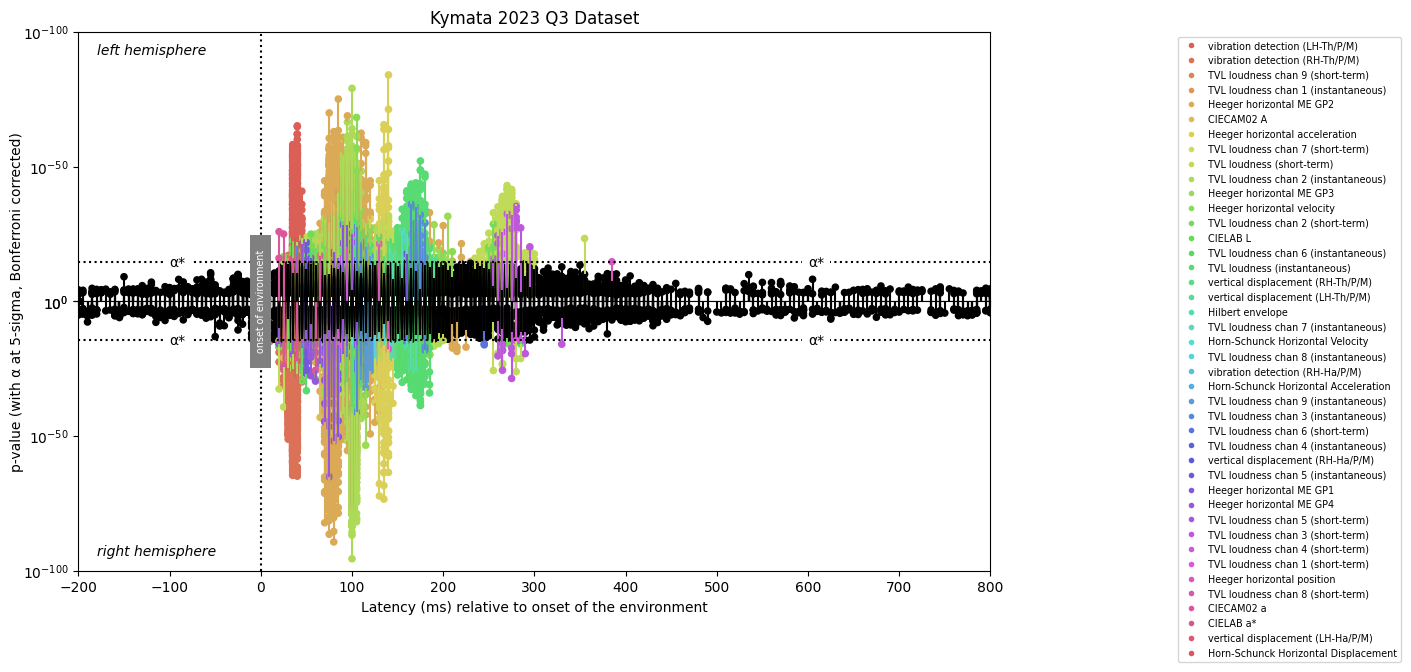

In [2]:
expression_set: HexelExpressionSet = KymataMirror2023Q3Dataset().to_expressionset()
hexels = build_hexel_dict_from_expression_set(expression_set)
hexels = convert_to_power10(hexels)
stem_plot(hexels, 'Kymata 2023 Q3 Dataset')

In [3]:
# call this for each dataset, each denoiser, each hemi. 
def evaluate(hexels, 
             denoiser, 
             func_hier, 
             inputs,
             hemi, 
             sensory_domain,
             normalise=False,
             posterior_pooling=False,
             cluster_latency=False,
             plotting=True):
    hexels = deepcopy(hexels)
    denoised = denoiser.cluster(hexels, hemi, normalise, cluster_latency, posterior_pooling)
    if hemi == 'leftHemisphere':
        # we copy the left hemi of denoised into right hemi of hexels.
        # copy(hexels_to, hexels_from, hemi_to, hemi_from
        copy_hemisphere(hexels, denoised, 'rightHemisphere', 'leftHemisphere')
    else:
        copy_hemisphere(hexels, denoised, 'leftHemisphere', 'rightHemisphere')

    builder = IPPMBuilder()
    plotter = IPPMPlotter()
    graph = builder.build_graph(denoised, func_hier, inputs, hemi)

    funcs = list(set(func_hier.keys()).difference(set(inputs)))
    func_recall = function_recall(hexels, funcs, graph, hemi)
    cvs = causality_violation_score(denoised, func_hier, hemi, inputs)

    if plotting:
        stem_plot(denoised, f'{sensory_domain} {hemi} denoised time-series vs noisy.')
        
    return (
        func_recall,
        cvs,
        graph
    )

In [4]:
plotter = IPPMPlotter()

In [5]:
def print_scores(label, fr, cvs):
    print(f'{label} :: Function Recall: {fr[0]:.3f} | Funcs Found: {fr[1]} | Total Funcs: {fr[2]}')
    print(f'{label} :: Causality Violation: {cvs[0]:.3f} | Violations Found: {cvs[1]} | Total Arrows: {cvs[2]}')

In [6]:
def avg_scores(label, indiv_frs, indiv_cvs):
    mean = lambda indiv_xs: sum(x[0] for x in indiv_xs) / len(indiv_xs)
    print(f'{label} :: Avg FR: {mean(indiv_frs):.3f} | Avg CVS: {mean(indiv_cvs):.3f}')

In [7]:
s1_inputs = ['input_cochlear']
s1_function_hier = {
        # assumption: we have a list of functions and their children function
        'TVL loudness (short-term)' : ['TVL loudness (instantaneous)'],
        'TVL loudness (instantaneous)' : [
                'TVL loudness chan 1 (instantaneous)',
                'TVL loudness chan 2 (instantaneous)',
                'TVL loudness chan 3 (instantaneous)',
                'TVL loudness chan 4 (instantaneous)',
                'TVL loudness chan 5 (instantaneous)',
                'TVL loudness chan 6 (instantaneous)',
                'TVL loudness chan 7 (instantaneous)',
                'TVL loudness chan 8 (instantaneous)',
                'TVL loudness chan 9 (instantaneous)'],
        'TVL loudness chan 1 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 2 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 3 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 4 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 5 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 6 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 7 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 8 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 9 (instantaneous)' : ['input_cochlear'],
        'input_cochlear' : []
    }
s1_function_colour_overrides = {
        # Functions and their colours to match the figures
        'TVL loudness (short-term)' : '#d388b5',
        'TVL loudness (instantaneous)' : '#b11e34',
        'TVL loudness chan 1 (instantaneous)' : '#a201e9',
        'TVL loudness chan 2 (instantaneous)' : '#a201e9',
        'TVL loudness chan 3 (instantaneous)' : '#a201e9',
        'TVL loudness chan 4 (instantaneous)' : '#a201e9',
        'TVL loudness chan 5 (instantaneous)' : '#a201e9',
        'TVL loudness chan 6 (instantaneous)' : '#a201e9',
        'TVL loudness chan 7 (instantaneous)' : '#a201e9',
        'TVL loudness chan 8 (instantaneous)' : '#a201e9',
        'TVL loudness chan 9 (instantaneous)' : '#a201e9',
        'input_cochlear' : '#7e7e7e'
    }

In [42]:
s2_inputs = ['input_photoreceptors']
s2_function_hier = {
    'Heeger horizontal acceleration' : ['Heeger horizontal velocity'],
    'Heeger horizontal velocity' : [
            'Heeger horizontal ME GP1', 
            'Heeger horizontal ME GP2', 
            'Heeger horizontal ME GP3'],
    'Heeger horizontal ME GP1' : ['input_photoreceptors'],
    'Heeger horizontal ME GP2' : ['input_photoreceptors'],
    'Heeger horizontal ME GP3' : ['input_photoreceptors'],
    'input_photoreceptors' : []
}
s2_function_colour_overrides = {
        # Functions and their colours to match the figures
        'Heeger horizontal acceleration' : '#68d366',
        'Heeger horizontal velocity' : '#3165e0',
        'Heeger horizontal ME GP1' : '#fdf351',
        'Heeger horizontal ME GP2' : '#f8d748',
        'Heeger horizontal ME GP3' : '#eda13a',
        'Heeger horizontal ME GP4' : '#ed732e',
        'input_photoreceptors' : '#7e7e7e'
    }

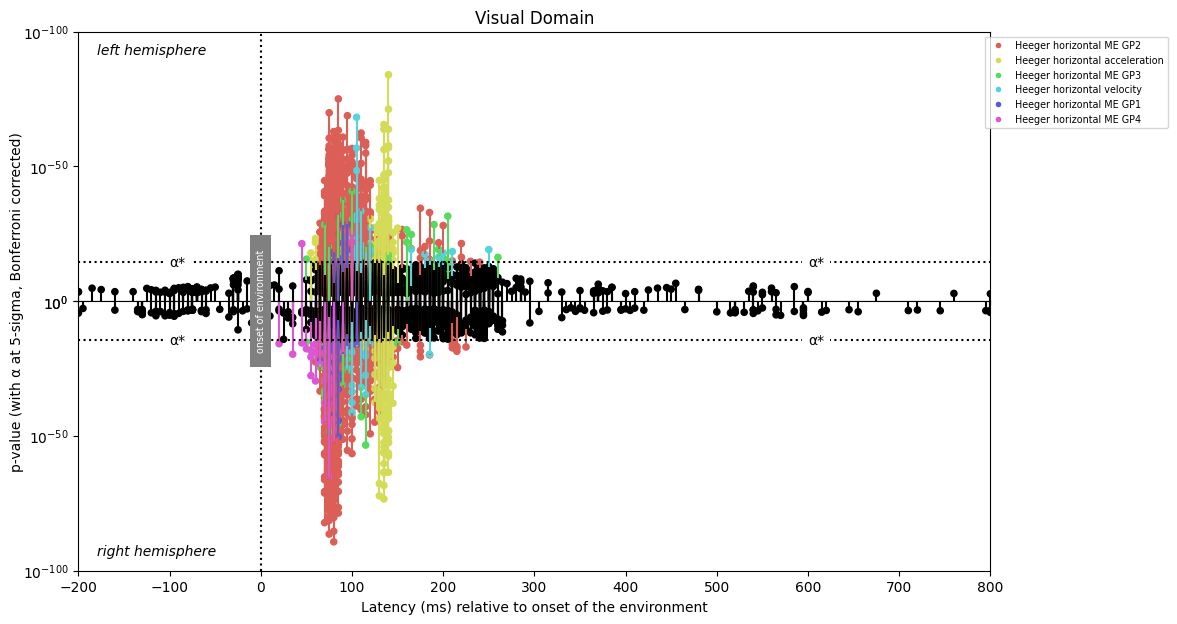

In [11]:
visual_funcs = [
    'Heeger horizontal acceleration',
    'Heeger horizontal velocity',
    'Heeger horizontal ME GP1', 
    'Heeger horizontal ME GP2', 
    'Heeger horizontal ME GP3',
    'Heeger horizontal ME GP4'
]
visual_hexels = deepcopy(hexels)
funcs = list(hexels.keys())
for func in funcs:
    if func not in visual_funcs:
        visual_hexels.pop(func)
stem_plot(visual_hexels, 'Visual Domain')

### Hyperparameter Selection

We will go through each denoiser and calculate the avg FR and CVS per hyperparameter configuration. We select the configuration with the best balance between CVS (minimise) and FR (maximise).

We first look for the maximum FR since causality violation can easily be improved by using things like posterior pooling. If the maximum FR always has a poor CVS, we can resort to opting for a lower FR. Anyway, first we find the maximum FR, then the minimum CVS with the maximum FR.

## Note to future Ani: should've parallelised this tho

#### Max Pooler

In [16]:
# Optimal config: threshold: 1 | Bin size: 1000

thresholds = [1, 2, 5, 10, 15, 20, 30]
bin_sizes = [5, 10, 15, 20, 25, 30, 1000]
for threshold in thresholds:
    for bin_sz in bin_sizes:
        mp = MaxPooler(threshold=threshold, bin_sz=bin_sz)
        s1_l_fr, s1_l_cvs, _ = evaluate(hexels, mp, s1_function_hier, s1_inputs, 'leftHemisphere', 'temp', plotting=False)
        s1_r_fr, s1_r_cvs, _ = evaluate(hexels, mp, s1_function_hier, s1_inputs, 'rightHemisphere', 'temp', plotting=False)
        s2_l_fr, s2_l_cvs, _ = evaluate(hexels, mp, s2_function_hier, s2_inputs, 'leftHemisphere', 'temp', plotting=False)
        s2_r_fr, s2_r_cvs, _ = evaluate(hexels, mp, s2_function_hier, s2_inputs, 'rightHemisphere', 'temp', plotting=False)
        avg_fr = (s1_l_fr[0] + s1_r_fr[0] + s2_l_fr[0] + s2_r_fr[0]) / 4
        avg_cvs = (s1_l_cvs[0] + s1_r_cvs[0] + s2_l_cvs[0] + s2_r_cvs[0]) / 4
        print(f'Threshold: {threshold} | Bin size: {bin_sz} | AVG FR: {avg_fr:.3f} | AVG CVS: {avg_cvs:.3f}')

Threshold: 1 | Bin size: 5 | AVG FR: 1.000 | AVG CVS: 0.516
Threshold: 1 | Bin size: 10 | AVG FR: 1.000 | AVG CVS: 0.516
Threshold: 1 | Bin size: 15 | AVG FR: 1.000 | AVG CVS: 0.516
Threshold: 1 | Bin size: 20 | AVG FR: 1.000 | AVG CVS: 0.516
Threshold: 1 | Bin size: 25 | AVG FR: 1.000 | AVG CVS: 0.516
Threshold: 1 | Bin size: 30 | AVG FR: 1.000 | AVG CVS: 0.516
Threshold: 1 | Bin size: 1000 | AVG FR: 1.000 | AVG CVS: 0.124
Threshold: 2 | Bin size: 5 | AVG FR: 1.000 | AVG CVS: 0.428
Threshold: 2 | Bin size: 10 | AVG FR: 1.000 | AVG CVS: 0.428
Threshold: 2 | Bin size: 15 | AVG FR: 1.000 | AVG CVS: 0.413
Threshold: 2 | Bin size: 20 | AVG FR: 1.000 | AVG CVS: 0.413
Threshold: 2 | Bin size: 25 | AVG FR: 1.000 | AVG CVS: 0.428
Threshold: 2 | Bin size: 30 | AVG FR: 1.000 | AVG CVS: 0.413
Threshold: 2 | Bin size: 1000 | AVG FR: 1.000 | AVG CVS: 0.124
Threshold: 5 | Bin size: 5 | AVG FR: 0.844 | AVG CVS: 0.357
Threshold: 5 | Bin size: 10 | AVG FR: 0.894 | AVG CVS: 0.342
Threshold: 5 | Bin size

#### Adaptive Max Pooler

In [17]:
# Optimal Config: Threshold = 1 | Base Bin Size = 1000.

thresholds = [1, 2, 3, 4, 5, 10, 15, 20]
bin_sizes = [5, 10, 15, 20, 25, 1000]
for threshold in thresholds:
    for bin_sz in bin_sizes:
        amp = AdaptiveMaxPooler(threshold=threshold, base_bin_sz=bin_sz)
        s1_l_fr, s1_l_cvs, _ = evaluate(hexels, amp, s1_function_hier, s1_inputs, 'leftHemisphere', 'temp', plotting=False)
        s1_r_fr, s1_r_cvs, _ = evaluate(hexels, amp, s1_function_hier, s1_inputs, 'rightHemisphere', 'temp', plotting=False)
        s2_l_fr, s2_l_cvs, _ = evaluate(hexels, amp, s2_function_hier, s2_inputs, 'leftHemisphere', 'temp', plotting=False)
        s2_r_fr, s2_r_cvs, _ = evaluate(hexels, amp, s2_function_hier, s2_inputs, 'rightHemisphere', 'temp', plotting=False)
        avg_fr = (s1_l_fr[0] + s1_r_fr[0] + s2_l_fr[0] + s2_r_fr[0]) / 4
        avg_cvs = (s1_l_cvs[0] + s1_r_cvs[0] + s2_l_cvs[0] + s2_r_cvs[0]) / 4
        print(f'Threshold: {threshold} | Base Bin size: {bin_sz} | AVG FR: {avg_fr:.3f} | AVG CVS: {avg_cvs:.3f}')

Threshold: 1 | Base Bin size: 5 | AVG FR: 1.000 | AVG CVS: 0.516
Threshold: 1 | Base Bin size: 10 | AVG FR: 1.000 | AVG CVS: 0.444
Threshold: 1 | Base Bin size: 15 | AVG FR: 1.000 | AVG CVS: 0.400
Threshold: 1 | Base Bin size: 20 | AVG FR: 1.000 | AVG CVS: 0.364
Threshold: 1 | Base Bin size: 25 | AVG FR: 1.000 | AVG CVS: 0.264
Threshold: 1 | Base Bin size: 1000 | AVG FR: 1.000 | AVG CVS: 0.124
Threshold: 2 | Base Bin size: 5 | AVG FR: 1.000 | AVG CVS: 0.377
Threshold: 2 | Base Bin size: 10 | AVG FR: 1.000 | AVG CVS: 0.413
Threshold: 2 | Base Bin size: 15 | AVG FR: 1.000 | AVG CVS: 0.377
Threshold: 2 | Base Bin size: 20 | AVG FR: 1.000 | AVG CVS: 0.341
Threshold: 2 | Base Bin size: 25 | AVG FR: 1.000 | AVG CVS: 0.176
Threshold: 2 | Base Bin size: 1000 | AVG FR: 1.000 | AVG CVS: 0.124
Threshold: 3 | Base Bin size: 5 | AVG FR: 0.975 | AVG CVS: 0.360
Threshold: 3 | Base Bin size: 10 | AVG FR: 0.975 | AVG CVS: 0.393
Threshold: 3 | Base Bin size: 15 | AVG FR: 0.975 | AVG CVS: 0.376
Threshold

#### GMM

In [18]:
# Optimal Config: max_gaussian = 2 | covariance_type = full | init_params = random_from_data | is_aic = False

max_gaussians = [2, 3, 5, 7, 10]
covariance_types = ['full', 'tied', 'diag', 'spherical']
init_params = ['kmeans', 'k-means++', 'random', 'random_from_data']
is_aic = [True, False]
for max_gaussian in max_gaussians:
    for covar_type in covariance_types:
        for init_param in init_params:
            for aic in is_aic:
                gmm = GMM(max_gaussians=max_gaussian, 
                          covariance_type=covar_type,
                          init_params=init_param,
                          is_aic=aic)
                try:
                    s1_l_fr, s1_l_cvs, _ = evaluate(hexels, gmm, s1_function_hier, s1_inputs, 'leftHemisphere', 'temp', plotting=False)
                    s1_r_fr, s1_r_cvs, _ = evaluate(hexels, gmm, s1_function_hier, s1_inputs, 'rightHemisphere', 'temp', plotting=False)
                    s2_l_fr, s2_l_cvs, _ = evaluate(hexels, gmm, s2_function_hier, s2_inputs, 'leftHemisphere', 'temp', plotting=False)
                    s2_r_fr, s2_r_cvs, _ = evaluate(hexels, gmm, s2_function_hier, s2_inputs, 'rightHemisphere', 'temp', plotting=False)
                    avg_fr = (s1_l_fr[0] + s1_r_fr[0] + s2_l_fr[0] + s2_r_fr[0]) / 4
                    avg_cvs = (s1_l_cvs[0] + s1_r_cvs[0] + s2_l_cvs[0] + s2_r_cvs[0]) / 4
                    print(f'Max Gaussians: {max_gaussian} | Covar: {covar_type} | init_params: {init_param} | aic: {aic}'
                          + f'| AVG FR: {avg_fr:.3f} | AVG CVS: {avg_cvs:.3f}')
                except Exception:
                    print(f'Max Gaussians: {max_gaussian} | Covar: {covar_type} | init_params: {init_param} | aic: {aic}' + 'Failed to cluster, moving onto next one')

Max Gaussians: 2 | Covar: full | init_params: kmeans | aic: True| AVG FR: 1.000 | AVG CVS: 0.124
Max Gaussians: 2 | Covar: full | init_params: kmeans | aic: False| AVG FR: 1.000 | AVG CVS: 0.124
Max Gaussians: 2 | Covar: full | init_params: k-means++ | aic: True| AVG FR: 1.000 | AVG CVS: 0.124
Max Gaussians: 2 | Covar: full | init_params: k-means++ | aic: False| AVG FR: 1.000 | AVG CVS: 0.124
Max Gaussians: 2 | Covar: full | init_params: random | aic: True| AVG FR: 1.000 | AVG CVS: 0.124
Max Gaussians: 2 | Covar: full | init_params: random | aic: False| AVG FR: 1.000 | AVG CVS: 0.124
Max Gaussians: 2 | Covar: full | init_params: random_from_data | aic: True| AVG FR: 1.000 | AVG CVS: 0.124
Max Gaussians: 2 | Covar: full | init_params: random_from_data | aic: False| AVG FR: 1.000 | AVG CVS: 0.124
Max Gaussians: 2 | Covar: tied | init_params: kmeans | aic: True| AVG FR: 1.000 | AVG CVS: 0.124
Max Gaussians: 2 | Covar: tied | init_params: kmeans | aic: False| AVG FR: 1.000 | AVG CVS: 0.124

#### DBSCAN

In [10]:
"""
    Metrics 101
    -----------

    Random note: if doing t-SNE, run SVD/PCA prior to compress input.
    
    We have a general form for metrics:

                                ( sum to n (x_i - y_i) ^ p ) ^ 1/p
    Let p = 1, we get L1
    Let p = 2, we get L2.
    Let p = infinity, we get lim p->inf (sum to n (x_i - y_i) ^ p ) ^ 1/p = max over i (x_i - y_i)
        I.e., it is the infinity norm.

    Cityblock: Equivalent to Manhatten distance. It sees how many square blocks you have to take
               to reach your destination. Logically, it does not make sense to use in this case.
               To calculate it, you simply need to find the distance horizontally and vertically.
               In converse, euclidean (or l2) calculates the hypothenuose.
    Cosine: Computes the angle between two vectors. Not as sensitive to magnitude as euclidean. However,
            it is not compataible here
    l2: see euclidean distance.
    bray-curtis: normalised city block distance. Not available
    canberra: weighted version of manhatten distance. I gather it is used when dealing with values
              close to zero.
    chebyshev: p = infinity. The infinity norm. The maximum distance between any pair of
               elements.
    dice: same as F1 score. Gauges similarity of two samples.
    hamming: # of common elements in both samples.
    jaccard: statistic to gauage the dissimilarity and diversity of sample sets.
             It is simply 1 - the intersection of two sets over the union.
             Not useful in this context (good for NLP however!).
    kulsinki: another set metric, not useful here.
    mahalanobis: euclidean distance on steroids. It computes the distance between a point P
                 and a distribution D. Visualise a high-dimensional pdf. Mahanalobis computes
                 the distance from the mean of that PDF to P. If we scale each axis, we get euclidean.
                 Requires an additional parameter, inverse of covariance matrix. This is the hinderance as we have
                 are working with a time-series. We could substitute autocorrelation matrix instead. We won't use it
                 since we aren't working with probability distributions.
    minkowski: general form of distance metric. We won't use it.
    sokalmichener: dont use since it is used between boolean arrays.
    sokalsneath: boolean arrays so avoid
    seuclidean: standardised euclidean. Standardisation doesnt help (from experiments) and we require correlation also.
    sq-euclidean: squared euclidean. Not available.
    yule: between two boolean arrays, so skip.

    NOTE: we can actually use all of the boolean arrays ones by simply decomposing each vector
          into binary digits. However, this does not make much sense imo.
"""

# Optimal Config: metric = chebyshev or euclidean (they give same perf) | algorithm = indifferent to it (speeds up i guess)
#                 eps = 500 | min samples = 1.

eps = [500]#[5, 10, 15, 20, 30]
min_samples = [1, 2, 5, 10, 15]
metrics = ['euclidean', 'l1',  'chebyshev']
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
for ep in eps:
    for min_sample in min_samples:
        for metric in metrics:
            for algorithm in algorithms:
                db = DBSCAN(eps=ep, 
                             min_samples=min_sample,
                             metric=metric,
                             algorithm=algorithm)
                s1_l_fr, s1_l_cvs, _ = evaluate(hexels, db, s1_function_hier, s1_inputs, 'leftHemisphere', 'temp', plotting=False)
                s1_r_fr, s1_r_cvs, _ = evaluate(hexels, db, s1_function_hier, s1_inputs, 'rightHemisphere', 'temp', plotting=False)
                s2_l_fr, s2_l_cvs, _ = evaluate(hexels, db, s2_function_hier, s2_inputs, 'leftHemisphere', 'temp', plotting=False)
                s2_r_fr, s2_r_cvs, _ = evaluate(hexels, db, s2_function_hier, s2_inputs, 'rightHemisphere', 'temp', plotting=False)
                avg_fr = (s1_l_fr[0] + s1_r_fr[0] + s2_l_fr[0] + s2_r_fr[0]) / 4
                avg_cvs = (s1_l_cvs[0] + s1_r_cvs[0] + s2_l_cvs[0] + s2_r_cvs[0]) / 4
                print(f'Eps: {ep} | Min samples: {min_sample} | metric: {metric} | algorithm: {algorithm} | AVG FR: {avg_fr:.3f} | AVG CVS: {avg_cvs:.3f}')

Eps: 500 | Min samples: 1 | metric: euclidean | algorithm: auto | AVG FR: 1.000 | AVG CVS: 0.124
Eps: 500 | Min samples: 1 | metric: euclidean | algorithm: ball_tree | AVG FR: 1.000 | AVG CVS: 0.124
Eps: 500 | Min samples: 1 | metric: euclidean | algorithm: kd_tree | AVG FR: 1.000 | AVG CVS: 0.124
Eps: 500 | Min samples: 1 | metric: euclidean | algorithm: brute | AVG FR: 1.000 | AVG CVS: 0.124
Eps: 500 | Min samples: 1 | metric: l1 | algorithm: auto | AVG FR: 1.000 | AVG CVS: 0.124
Eps: 500 | Min samples: 1 | metric: l1 | algorithm: ball_tree | AVG FR: 1.000 | AVG CVS: 0.124
Eps: 500 | Min samples: 1 | metric: l1 | algorithm: kd_tree | AVG FR: 1.000 | AVG CVS: 0.124
Eps: 500 | Min samples: 1 | metric: l1 | algorithm: brute | AVG FR: 1.000 | AVG CVS: 0.124
Eps: 500 | Min samples: 1 | metric: chebyshev | algorithm: auto | AVG FR: 1.000 | AVG CVS: 0.124


KeyboardInterrupt: 

#### Mean Shift

In [20]:
# Optimal Config: cluster_all = False | min_bin_freq = 1 | bandwidth = 1000

cluster_alls = [False, True]
bandwidths = [5, 10, 20, 30, 50, 100, 150, 200, 1000]
min_bin_freqs = [1, 2, 5, 10]
for cluster_all in cluster_alls:
    for bandwidth in bandwidths:
        for min_bin_freq in min_bin_freqs:
            ms = MeanShift(cluster_all=cluster_all, bandwidth=bandwidth, min_bin_freq=min_bin_freq)
            s1_l_fr, s1_l_cvs, _ = evaluate(hexels, ms, s1_function_hier, s1_inputs, 'leftHemisphere', 'temp', plotting=False)
            s1_r_fr, s1_r_cvs, _ = evaluate(hexels, ms, s1_function_hier, s1_inputs, 'rightHemisphere', 'temp', plotting=False)
            s2_l_fr, s2_l_cvs, _ = evaluate(hexels, ms, s2_function_hier, s2_inputs, 'leftHemisphere', 'temp', plotting=False)
            s2_r_fr, s2_r_cvs, _ = evaluate(hexels, ms, s2_function_hier, s2_inputs, 'rightHemisphere', 'temp', plotting=False)
            avg_fr = (s1_l_fr[0] + s1_r_fr[0] + s2_l_fr[0] + s2_r_fr[0]) / 4
            avg_cvs = (s1_l_cvs[0] + s1_r_cvs[0] + s2_l_cvs[0] + s2_r_cvs[0]) / 4
            print(f'cluster_all: {cluster_all} | bandwidth: {bandwidth} | min_bin_freq: {min_bin_freq} | AVG FR: {avg_fr:.3f} | AVG CVS: {avg_cvs:.3f}')

cluster_all: False | bandwidth: 5 | min_bin_freq: 1 | AVG FR: 1.000 | AVG CVS: 0.516
cluster_all: False | bandwidth: 5 | min_bin_freq: 2 | AVG FR: 1.000 | AVG CVS: 0.516
cluster_all: False | bandwidth: 10 | min_bin_freq: 1 | AVG FR: 1.000 | AVG CVS: 0.480
cluster_all: False | bandwidth: 10 | min_bin_freq: 2 | AVG FR: 1.000 | AVG CVS: 0.480
cluster_all: False | bandwidth: 20 | min_bin_freq: 1 | AVG FR: 1.000 | AVG CVS: 0.480
cluster_all: False | bandwidth: 20 | min_bin_freq: 2 | AVG FR: 1.000 | AVG CVS: 0.480
cluster_all: False | bandwidth: 30 | min_bin_freq: 1 | AVG FR: 1.000 | AVG CVS: 0.480
cluster_all: False | bandwidth: 30 | min_bin_freq: 2 | AVG FR: 1.000 | AVG CVS: 0.480
cluster_all: False | bandwidth: 50 | min_bin_freq: 1 | AVG FR: 1.000 | AVG CVS: 0.241
cluster_all: False | bandwidth: 50 | min_bin_freq: 2 | AVG FR: 1.000 | AVG CVS: 0.241
cluster_all: False | bandwidth: 100 | min_bin_freq: 1 | AVG FR: 1.000 | AVG CVS: 0.141
cluster_all: False | bandwidth: 100 | min_bin_freq: 2 |

## Auditory Domain

### MaxPooler

In [8]:
s1_mp_indiv_frs = []
s1_mp_indiv_cvs = []

#### LeftHemisphere

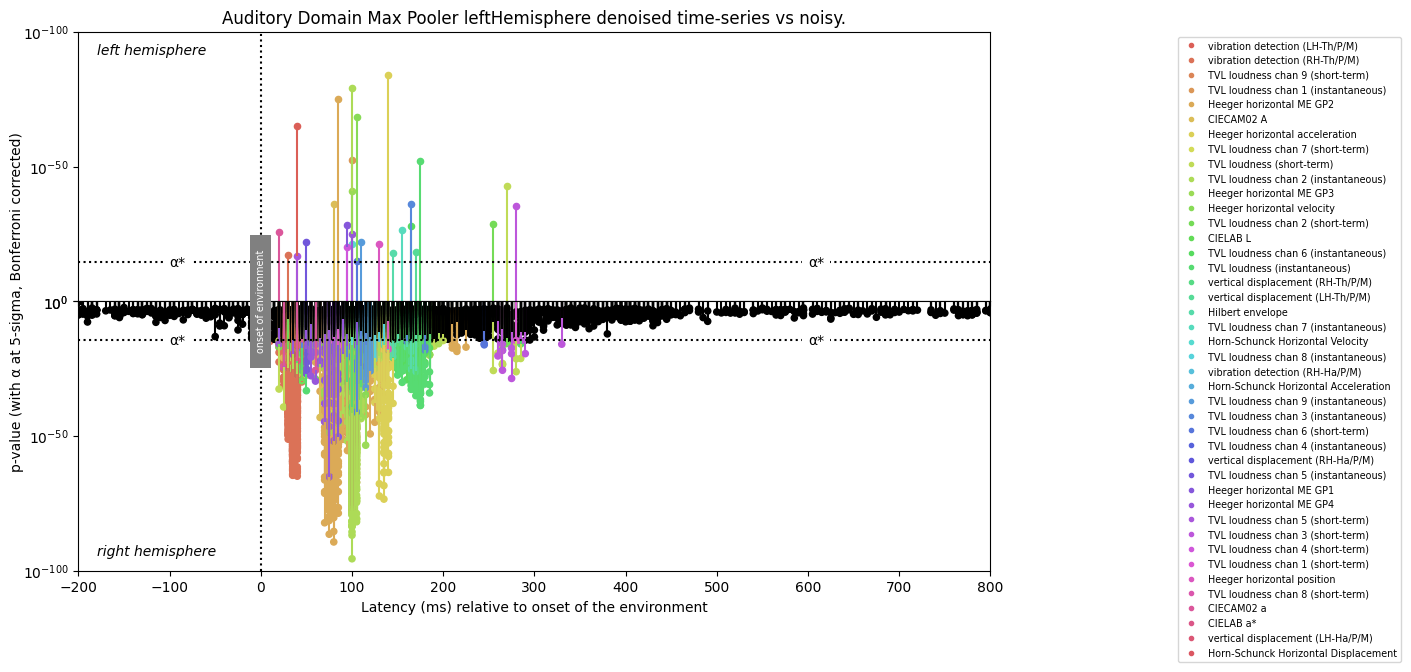

Auditory Domain Max Pooler leftHemi :: Function Recall: 1.000 | Funcs Found: 9 | Total Funcs: 9
Auditory Domain Max Pooler leftHemi :: Causality Violation: 0.000 | Violations Found: 0 | Total Arrows: 15


In [9]:
s1_mp_l = MaxPooler(threshold=1, bin_sz=1000)
s1_mp_l_fr, s1_mp_l_cvs, s1_mp_l_ippm = evaluate(hexels, s1_mp_l, s1_function_hier, s1_inputs, 'leftHemisphere', 'Auditory Domain Max Pooler')
s1_mp_indiv_frs.append(s1_mp_l_fr)
s1_mp_indiv_cvs.append(s1_mp_l_cvs)
print_scores('Auditory Domain Max Pooler leftHemi', s1_mp_l_fr, s1_mp_l_cvs)

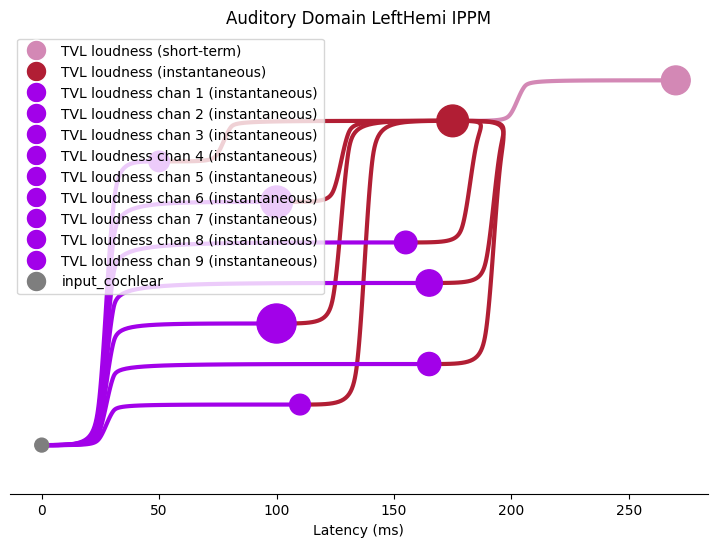

In [10]:
plotter.draw(s1_mp_l_ippm, s1_function_colour_overrides, 'Auditory Domain LeftHemi IPPM', 6, 9)

#### RightHemisphere

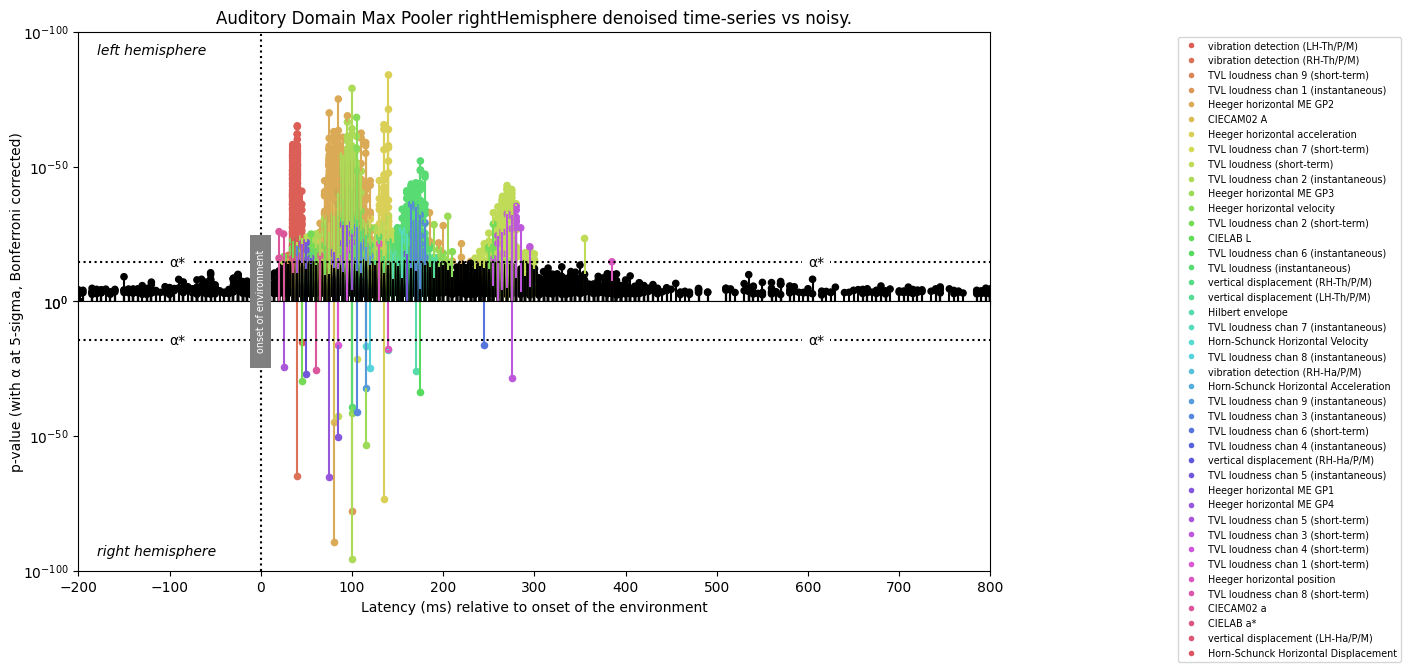

Auditory Domain Max Pooler rightHemi :: Function Recall: 1.000 | Funcs Found: 10 | Total Funcs: 10
Auditory Domain Max Pooler rightHemi :: Causality Violation: 0.353 | Violations Found: 6 | Total Arrows: 17


In [11]:
s1_mp_r = MaxPooler(threshold=1, bin_sz=1000)
s1_mp_r_fr, s1_mp_r_cvs, s1_mp_r_ippm = evaluate(hexels, s1_mp_r, s1_function_hier, s1_inputs, 'rightHemisphere', 'Auditory Domain Max Pooler')
s1_mp_indiv_frs.append(s1_mp_r_fr)
s1_mp_indiv_cvs.append(s1_mp_r_cvs)
print_scores('Auditory Domain Max Pooler rightHemi', s1_mp_r_fr, s1_mp_r_cvs)

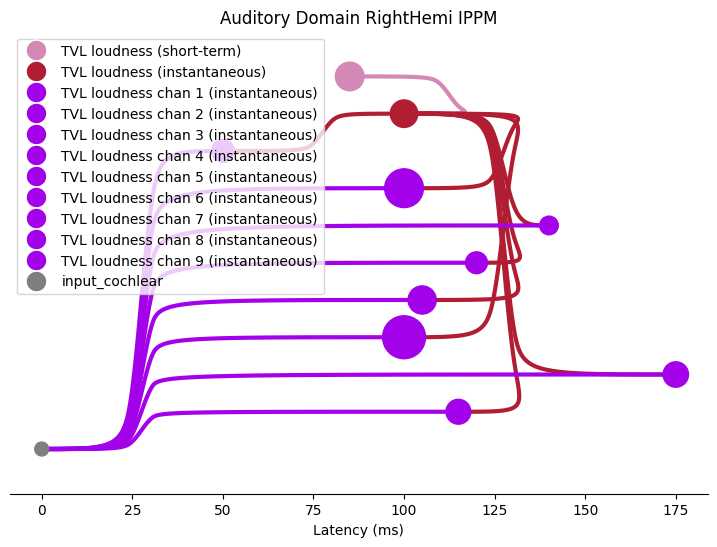

In [12]:
plotter.draw(s1_mp_r_ippm, s1_function_colour_overrides, 'Auditory Domain RightHemi IPPM', 6, 9)

#### Overall

In [13]:
avg_scores('Auditory Domain Max Pooler', s1_mp_indiv_frs, s1_mp_indiv_cvs)

Auditory Domain Max Pooler :: Avg FR: 1.000 | Avg CVS: 0.176


### Adaptive Max Pooler

In [16]:
s1_amp_indiv_frs = []
s1_amp_indiv_cvs = []

#### LeftHemisphere

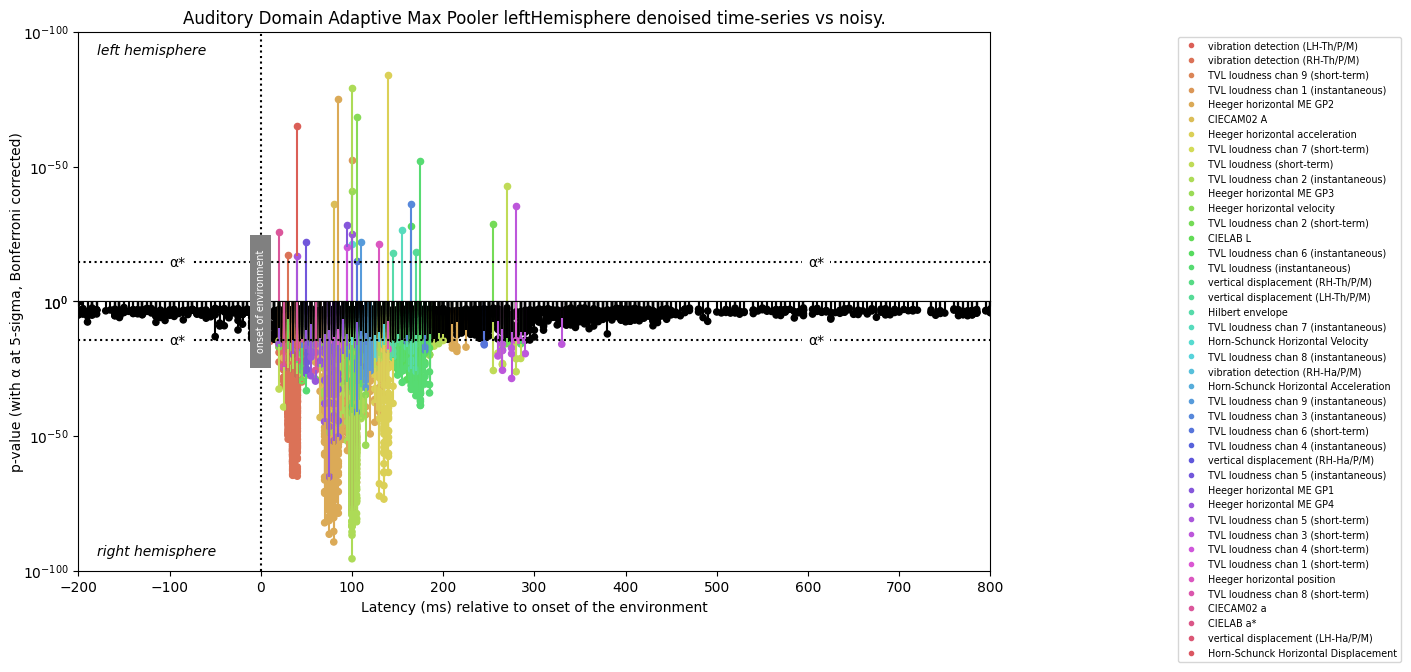

Auditory Domain Adaptive Max Pooler leftHemi :: Function Recall: 1.000 | Funcs Found: 9 | Total Funcs: 9
Auditory Domain Adaptive Max Pooler leftHemi :: Causality Violation: 0.000 | Violations Found: 0 | Total Arrows: 15


In [17]:
s1_amp_l = AdaptiveMaxPooler(threshold=1, base_bin_sz=1000)
s1_amp_l_fr, s1_amp_l_cvs, s1_amp_l_ippm = evaluate(hexels, s1_amp_l, s1_function_hier, s1_inputs, 'leftHemisphere', 'Auditory Domain Adaptive Max Pooler')
s1_amp_indiv_frs.append(s1_amp_l_fr)
s1_amp_indiv_cvs.append(s1_amp_l_cvs)
print_scores('Auditory Domain Adaptive Max Pooler leftHemi', s1_amp_l_fr, s1_amp_l_cvs)

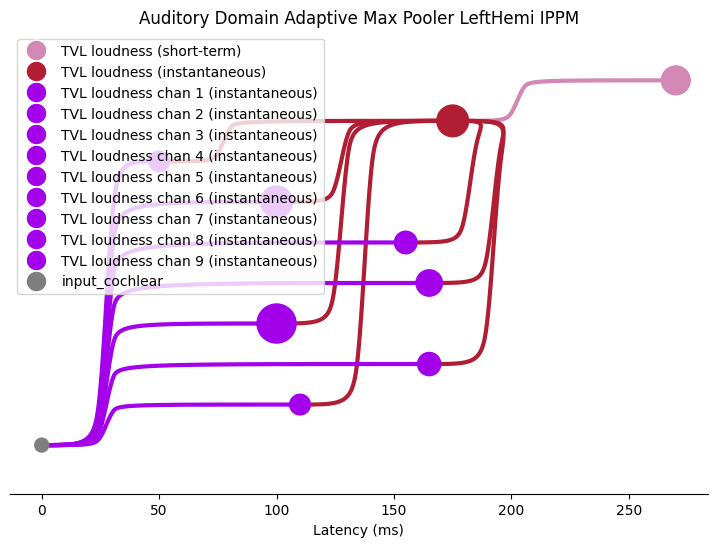

In [18]:
plotter.draw(s1_amp_l_ippm, s1_function_colour_overrides, 'Auditory Domain Adaptive Max Pooler LeftHemi IPPM', 6, 9)

#### RightHemisphere

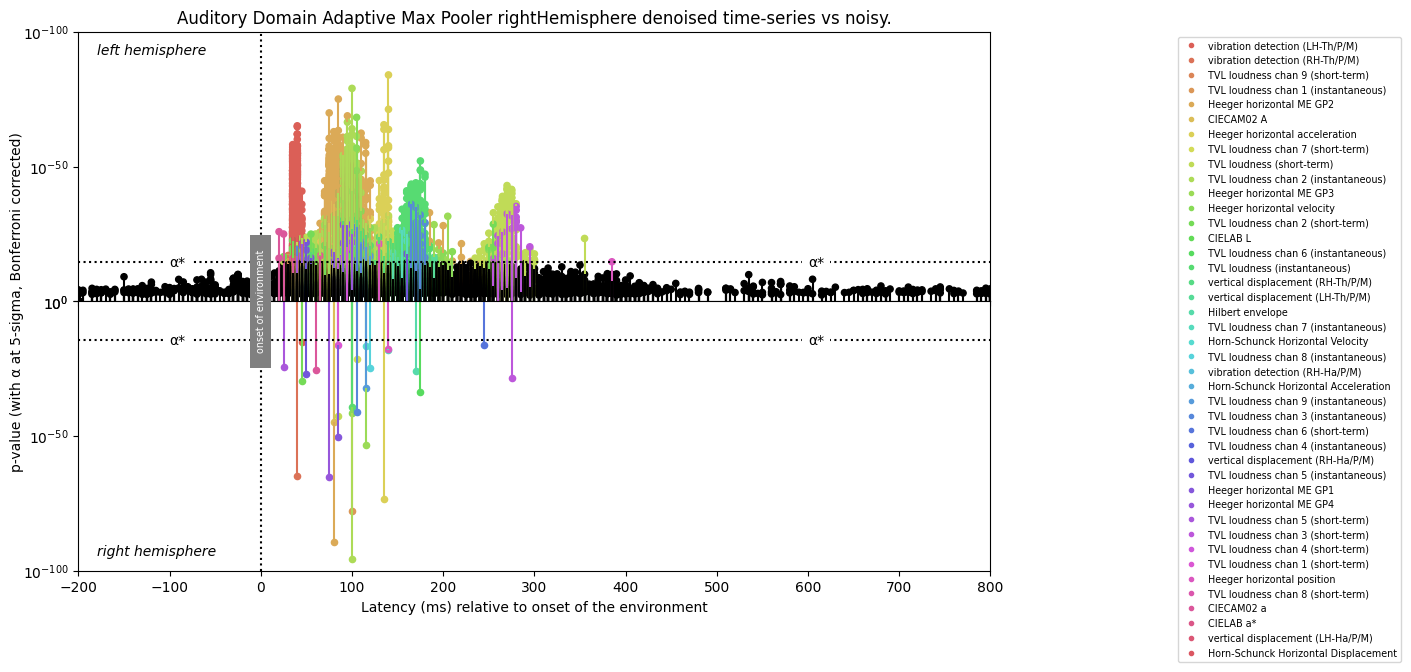

Auditory Domain Adaptive Max Pooler rightHemi :: Function Recall: 1.000 | Funcs Found: 10 | Total Funcs: 10
Auditory Domain Adaptive Max Pooler rightHemi :: Causality Violation: 0.353 | Violations Found: 6 | Total Arrows: 17


In [19]:
s1_amp_r = AdaptiveMaxPooler(threshold=1, base_bin_sz=1000)
s1_amp_r_fr, s1_amp_r_cvs, s1_amp_r_ippm = evaluate(hexels, s1_amp_r, s1_function_hier, s1_inputs, 'rightHemisphere', 'Auditory Domain Adaptive Max Pooler')
s1_amp_indiv_frs.append(s1_amp_r_fr)
s1_amp_indiv_cvs.append(s1_amp_r_cvs)
print_scores('Auditory Domain Adaptive Max Pooler rightHemi', s1_amp_r_fr, s1_amp_r_cvs)

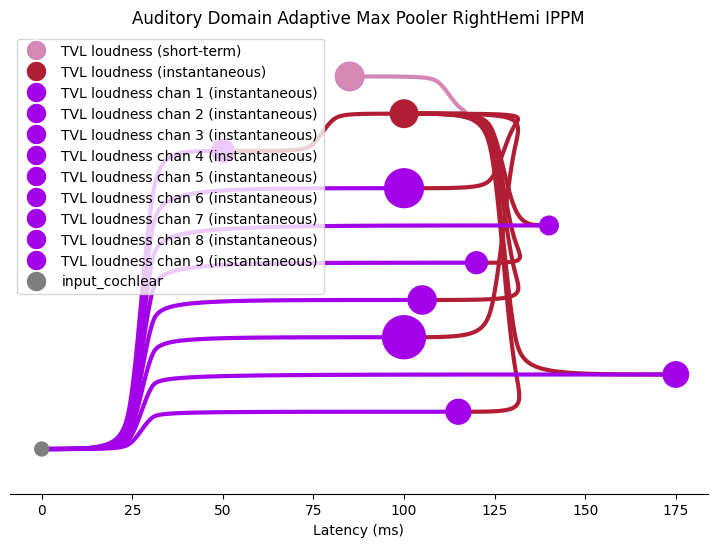

In [20]:
plotter.draw(s1_amp_r_ippm, s1_function_colour_overrides, 'Auditory Domain Adaptive Max Pooler RightHemi IPPM', 6, 9)

#### Overall

In [21]:
avg_scores('Auditory Domain Adaptive Max Pooler', s1_amp_indiv_frs, s1_amp_indiv_cvs)

Auditory Domain Adaptive Max Pooler :: Avg FR: 1.000 | Avg CVS: 0.176


### GMM

In [22]:
s1_gmm_indiv_frs = []
s1_gmm_indiv_cvs = []

#### LeftHemisphere

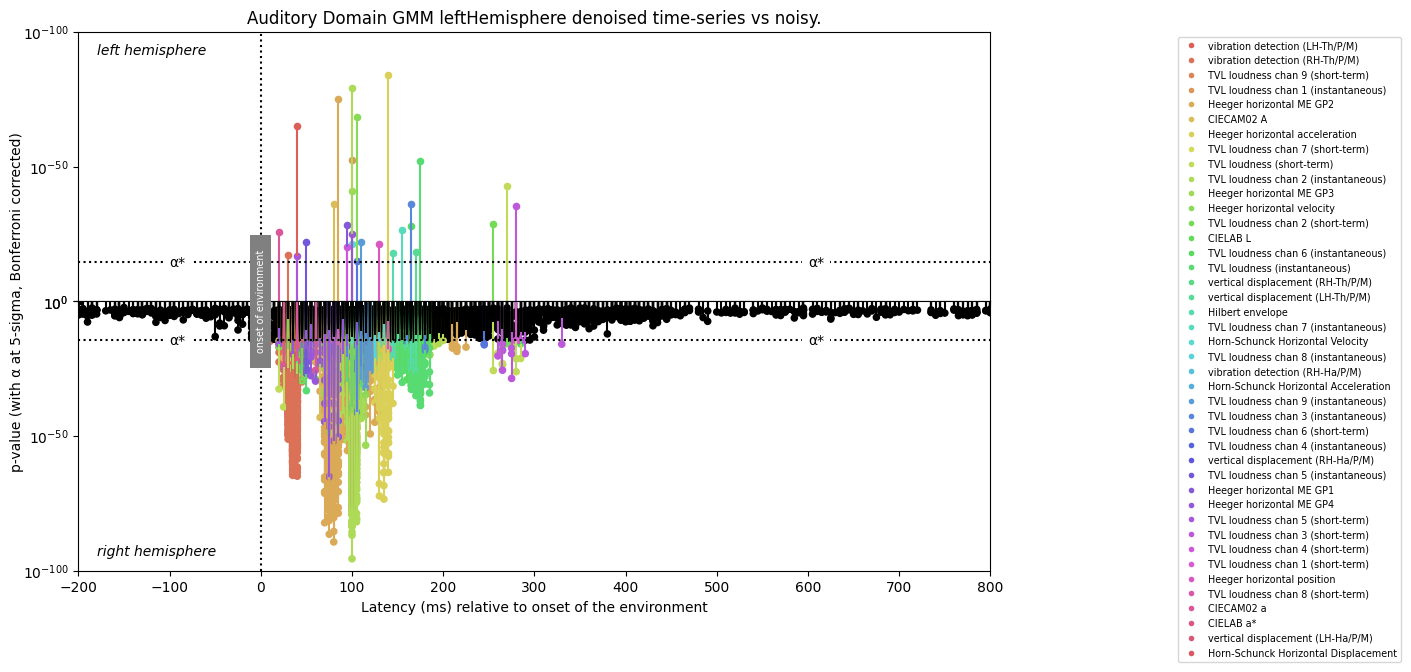

Auditory Domain GMM leftHemi :: Function Recall: 1.000 | Funcs Found: 9 | Total Funcs: 9
Auditory Domain GMM leftHemi :: Causality Violation: 0.000 | Violations Found: 0 | Total Arrows: 15


In [23]:
s1_gmm_l = GMM(max_gaussians=2, init_params='random_from_data', is_aic=False)
s1_gmm_l_fr, s1_gmm_l_cvs, s1_gmm_l_ippm = evaluate(hexels, s1_gmm_l, s1_function_hier, s1_inputs, 'leftHemisphere', 'Auditory Domain GMM')
s1_gmm_indiv_frs.append(s1_gmm_l_fr)
s1_gmm_indiv_cvs.append(s1_gmm_l_cvs)
print_scores('Auditory Domain GMM leftHemi', s1_gmm_l_fr, s1_gmm_l_cvs)

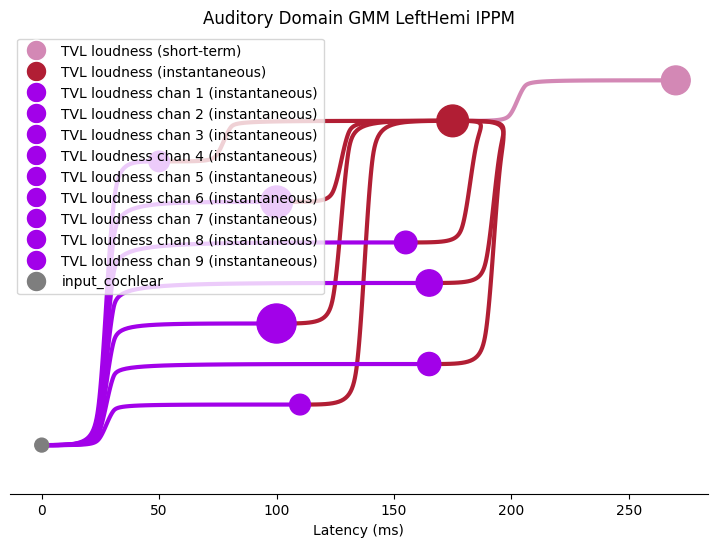

In [24]:
plotter.draw(s1_gmm_l_ippm, s1_function_colour_overrides, 'Auditory Domain GMM LeftHemi IPPM', 6, 9)

#### RightHemisphere

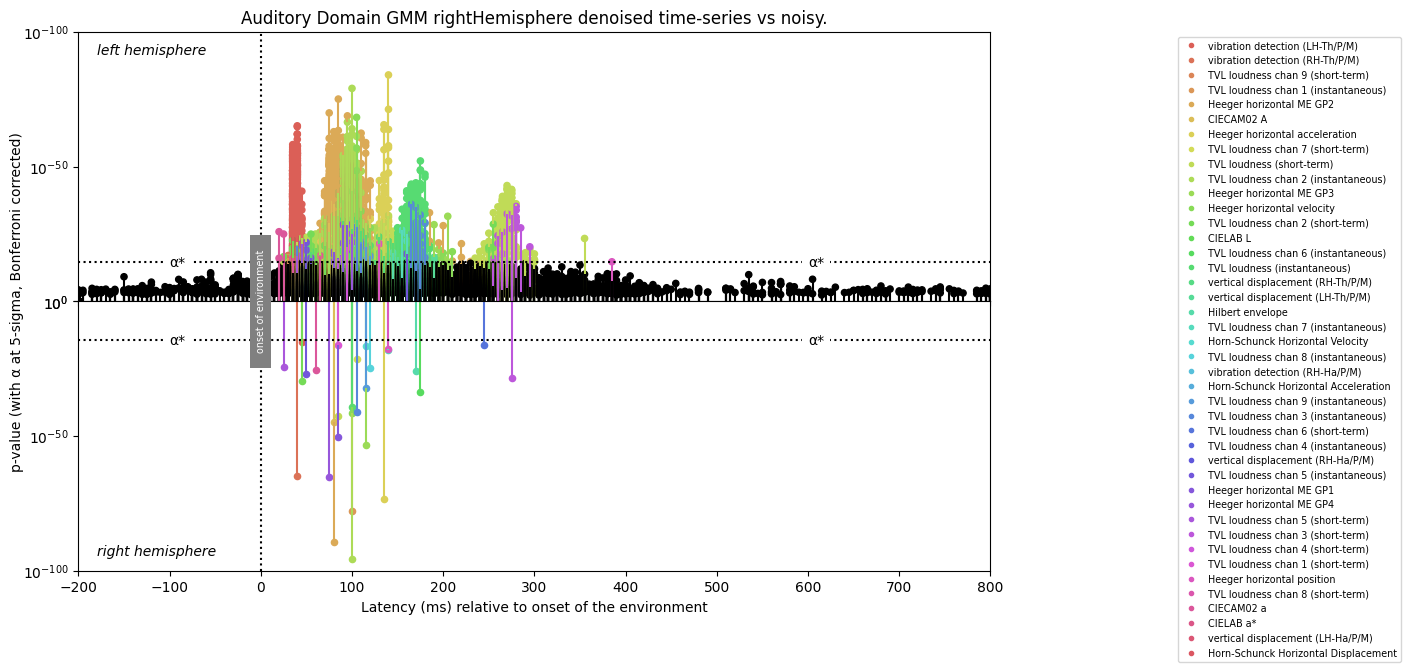

Auditory Domain GMM rightHemi :: Function Recall: 1.000 | Funcs Found: 10 | Total Funcs: 10
Auditory Domain GMM rightHemi :: Causality Violation: 0.353 | Violations Found: 6 | Total Arrows: 17


In [25]:
s1_gmm_r = GMM(max_gaussians=2, init_params='random_from_data', is_aic=False)
s1_gmm_r_fr, s1_gmm_r_cvs, s1_gmm_r_ippm = evaluate(hexels, s1_gmm_r, s1_function_hier, s1_inputs, 'rightHemisphere', 'Auditory Domain GMM')
s1_gmm_indiv_frs.append(s1_gmm_r_fr)
s1_gmm_indiv_cvs.append(s1_gmm_r_cvs)
print_scores('Auditory Domain GMM rightHemi', s1_gmm_r_fr, s1_gmm_r_cvs)

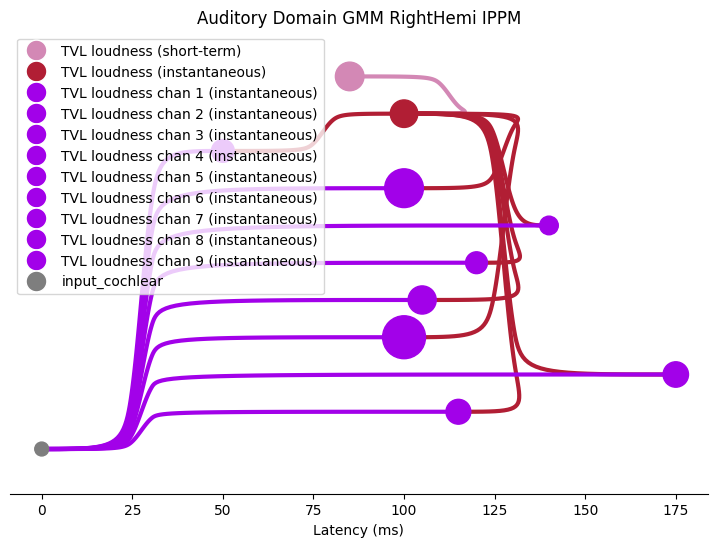

In [26]:
plotter.draw(s1_gmm_r_ippm, s1_function_colour_overrides, 'Auditory Domain GMM RightHemi IPPM', 6, 9)

#### Overall

In [27]:
avg_scores('Auditory Domain GMM', s1_gmm_indiv_frs, s1_gmm_indiv_cvs)

Auditory Domain GMM :: Avg FR: 1.000 | Avg CVS: 0.176


### DBSCAN

In [28]:
s1_db_indiv_frs = []
s1_db_indiv_cvs = []

#### LeftHemisphere

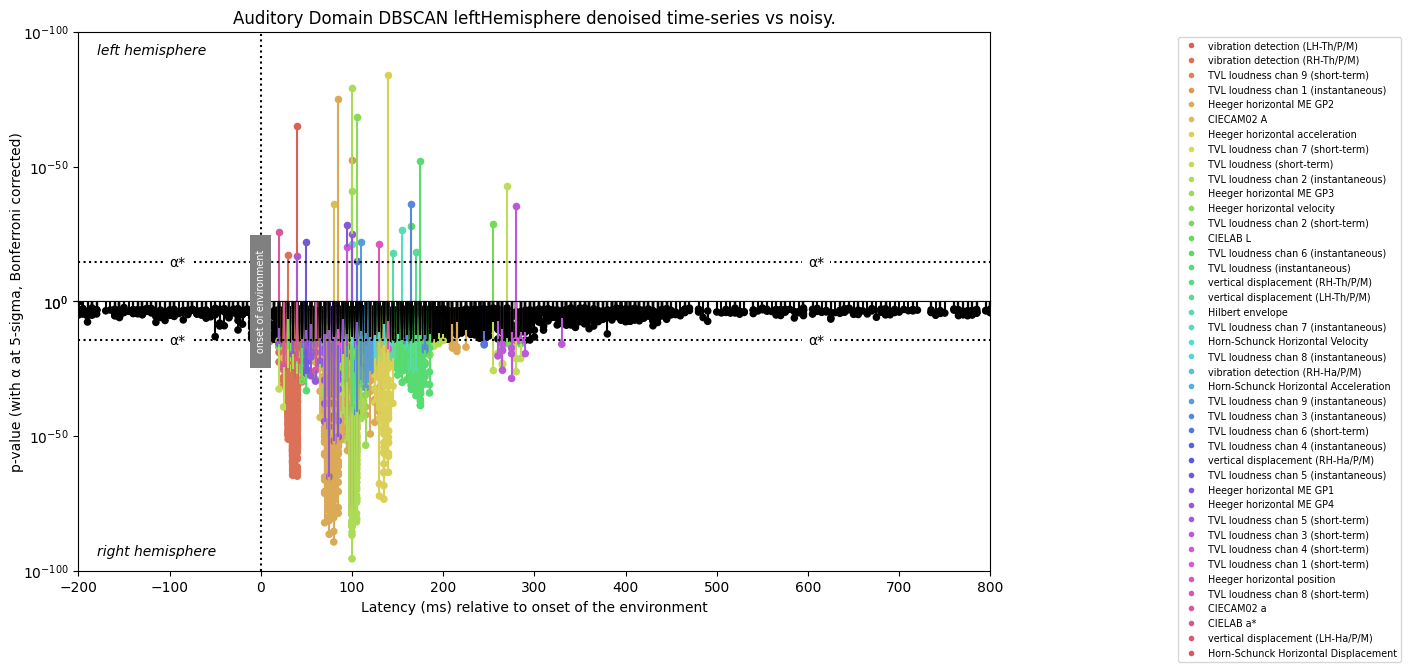

Auditory Domain Max Pooler leftHemi :: Function Recall: 1.000 | Funcs Found: 9 | Total Funcs: 9
Auditory Domain Max Pooler leftHemi :: Causality Violation: 0.000 | Violations Found: 0 | Total Arrows: 15


In [29]:
s1_db_l = DBSCAN(eps=500, min_samples=1)
s1_db_l_fr, s1_db_l_cvs, s1_db_l_ippm = evaluate(hexels, s1_db_l, s1_function_hier, s1_inputs, 'leftHemisphere', 'Auditory Domain DBSCAN')
s1_db_indiv_frs.append(s1_db_l_fr)
s1_db_indiv_cvs.append(s1_db_l_cvs)
print_scores('Auditory Domain Max Pooler leftHemi', s1_db_l_fr, s1_db_l_cvs)

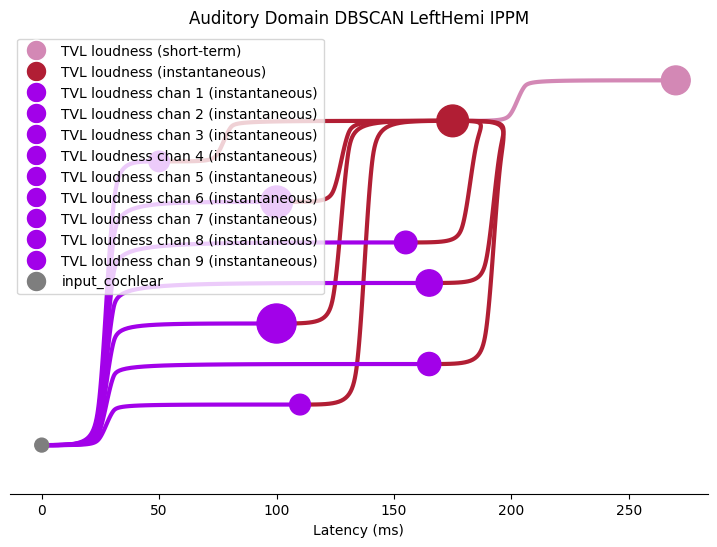

In [30]:
plotter.draw(s1_db_l_ippm, s1_function_colour_overrides, 'Auditory Domain DBSCAN LeftHemi IPPM', 6, 9)

#### RightHemisphere

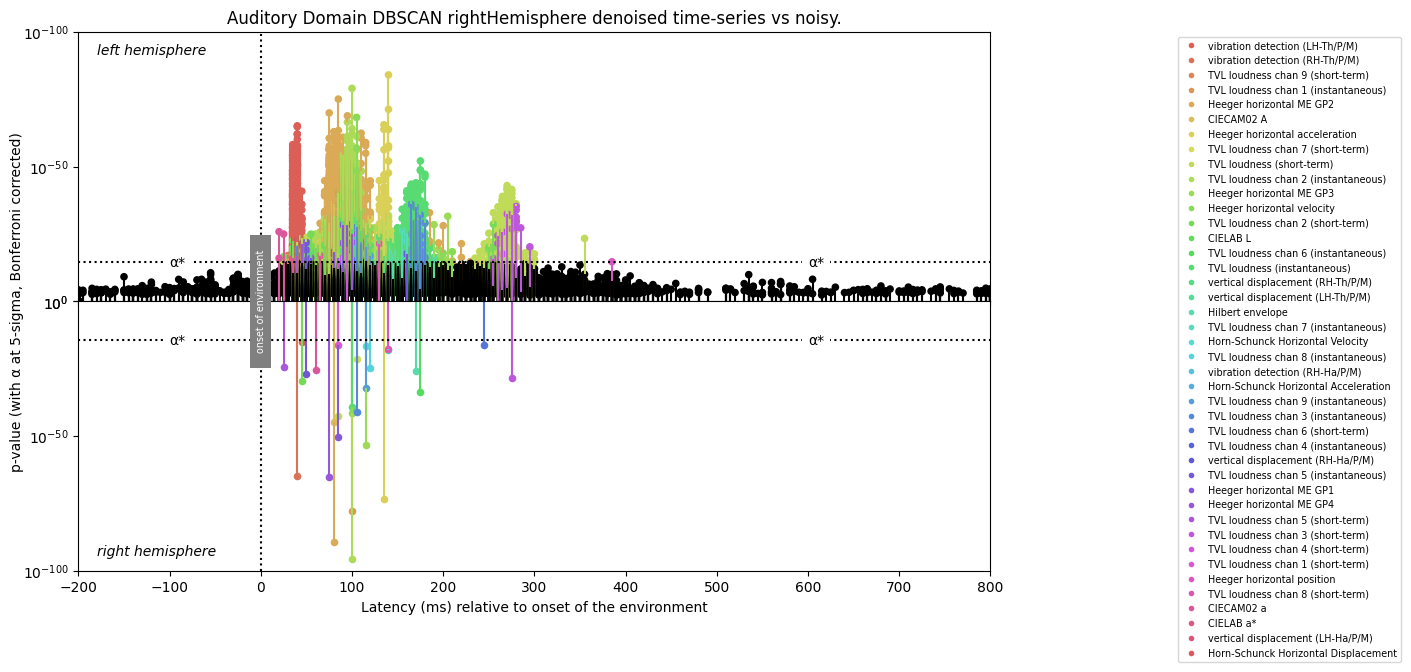

Auditory Domain DBSCAN rightHemi :: Function Recall: 1.000 | Funcs Found: 10 | Total Funcs: 10
Auditory Domain DBSCAN rightHemi :: Causality Violation: 0.353 | Violations Found: 6 | Total Arrows: 17


In [31]:
s1_db_r = DBSCAN(eps=500, min_samples=1)
s1_db_r_fr, s1_db_r_cvs, s1_db_r_ippm = evaluate(hexels, s1_db_r, s1_function_hier, s1_inputs, 'rightHemisphere', 'Auditory Domain DBSCAN')
s1_db_indiv_frs.append(s1_db_r_fr)
s1_db_indiv_cvs.append(s1_db_r_cvs)
print_scores('Auditory Domain DBSCAN rightHemi', s1_db_r_fr, s1_db_r_cvs)

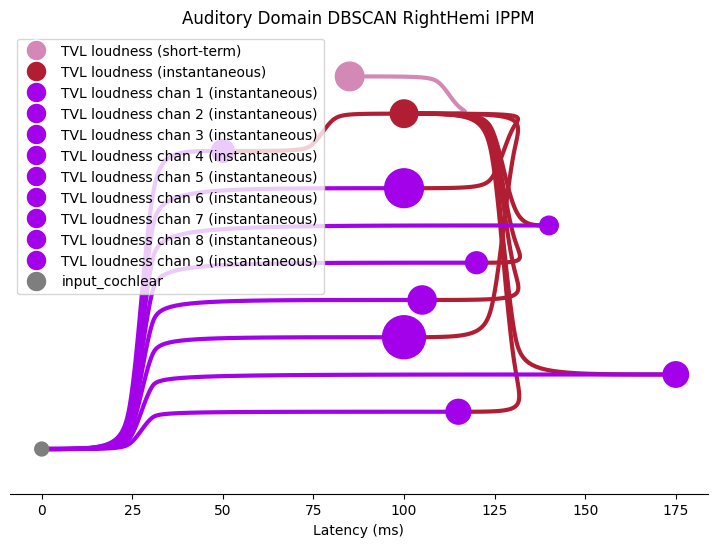

In [32]:
plotter.draw(s1_mp_r_ippm, s1_function_colour_overrides, 'Auditory Domain DBSCAN RightHemi IPPM', 6, 9)

#### Overall

In [33]:
avg_scores('Auditory Domain DBSCAN', s1_db_indiv_frs, s1_db_indiv_cvs)

Auditory Domain DBSCAN :: Avg FR: 1.000 | Avg CVS: 0.176


### Mean Shift

In [34]:
s1_ms_indiv_frs = []
s1_ms_indiv_cvs = []

#### LeftHemisphere

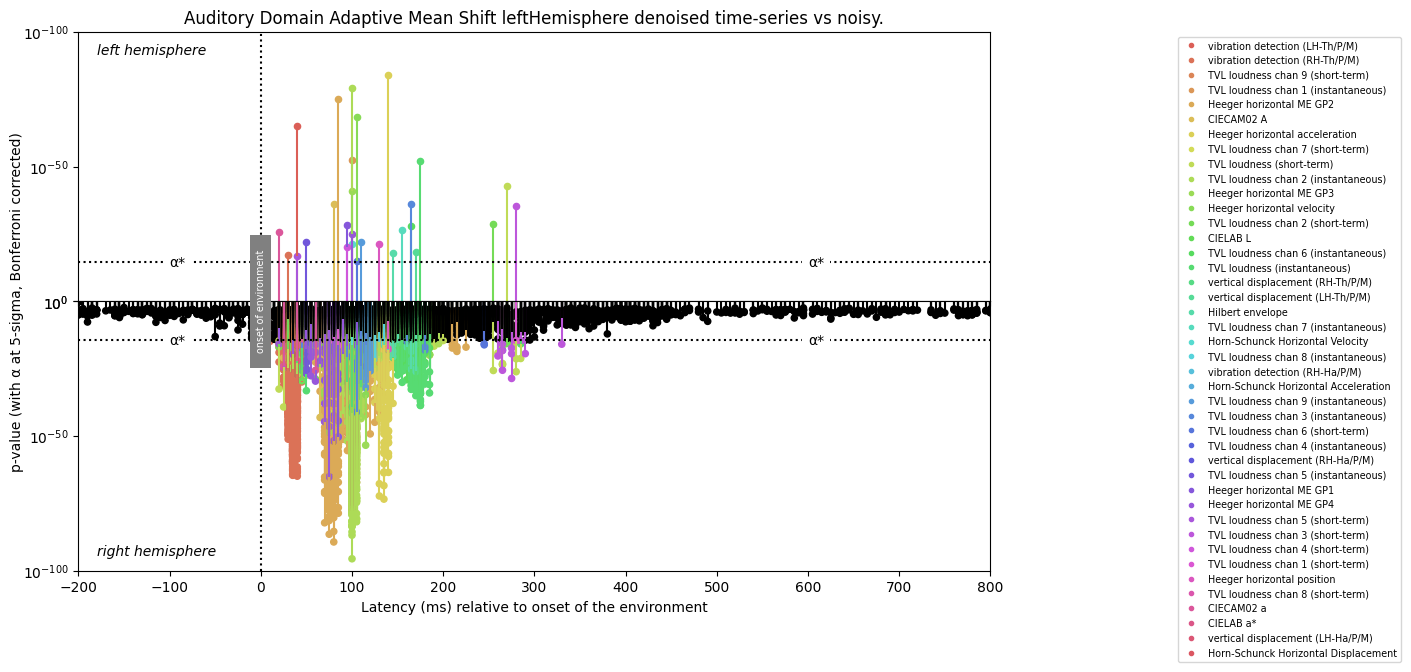

Auditory Domain Adaptive Max Pooler leftHemi :: Function Recall: 1.000 | Funcs Found: 9 | Total Funcs: 9
Auditory Domain Adaptive Max Pooler leftHemi :: Causality Violation: 0.000 | Violations Found: 0 | Total Arrows: 15


In [35]:
s1_ms_l = MeanShift(cluster_all=False, min_bin_freq=1, bandwidth=500)
s1_ms_l_fr, s1_ms_l_cvs, s1_ms_l_ippm = evaluate(hexels, s1_ms_l, s1_function_hier, s1_inputs, 'leftHemisphere', 'Auditory Domain Adaptive Mean Shift')
s1_ms_indiv_frs.append(s1_ms_l_fr)
s1_ms_indiv_cvs.append(s1_ms_l_cvs)
print_scores('Auditory Domain Adaptive Max Pooler leftHemi', s1_ms_l_fr, s1_ms_l_cvs)

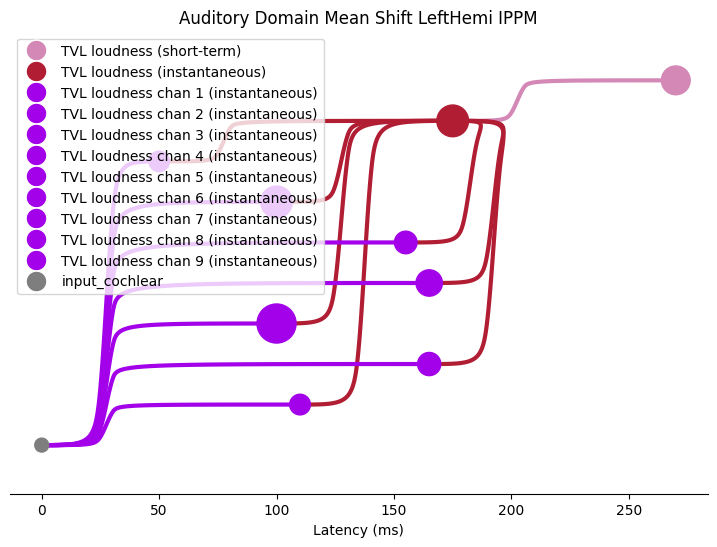

In [36]:
plotter.draw(s1_ms_l_ippm, s1_function_colour_overrides, 'Auditory Domain Mean Shift LeftHemi IPPM', 6, 9)

#### RightHemisphere

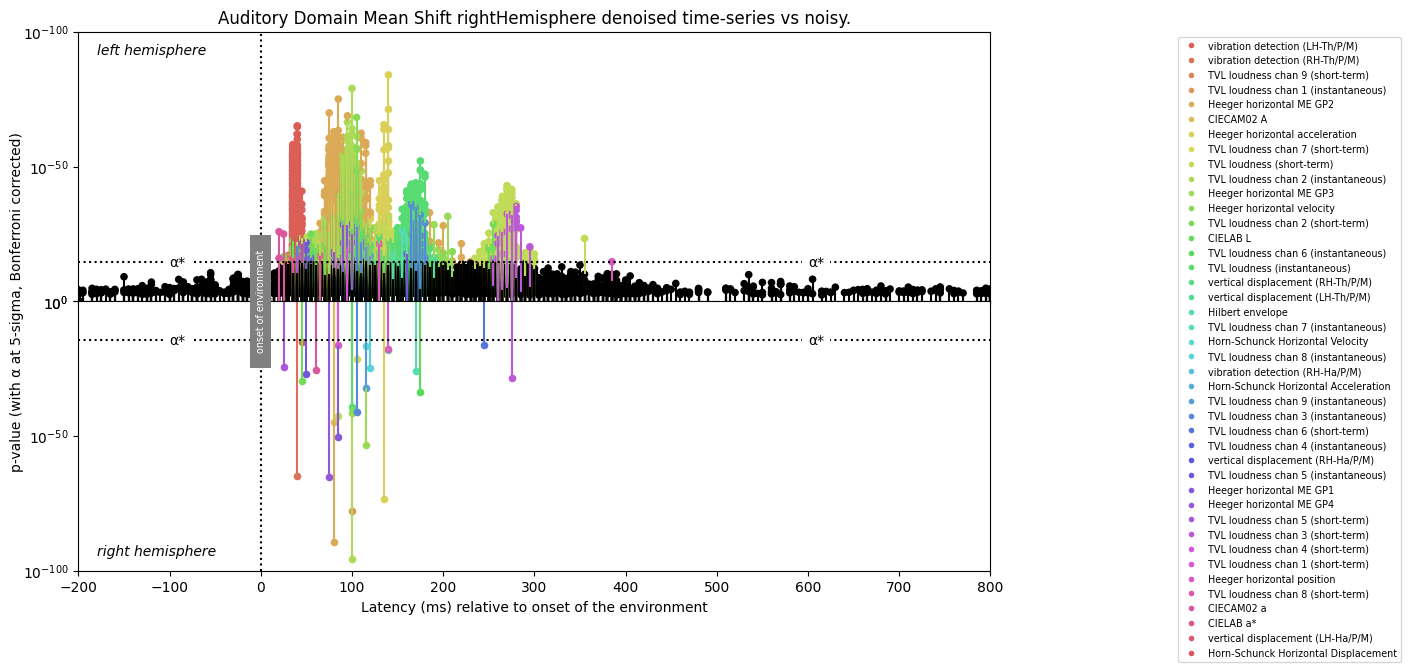

Auditory Domain Mean Shift rightHemi :: Function Recall: 1.000 | Funcs Found: 10 | Total Funcs: 10
Auditory Domain Mean Shift rightHemi :: Causality Violation: 0.353 | Violations Found: 6 | Total Arrows: 17


In [37]:
s1_ms_r = MeanShift(cluster_all=False, min_bin_freq=1, bandwidth=500)
s1_ms_r_fr, s1_ms_r_cvs, s1_ms_r_ippm = evaluate(hexels, s1_ms_r, s1_function_hier, s1_inputs, 'rightHemisphere', 'Auditory Domain Mean Shift')
s1_ms_indiv_frs.append(s1_ms_r_fr)
s1_ms_indiv_cvs.append(s1_ms_r_cvs)
print_scores('Auditory Domain Mean Shift rightHemi', s1_ms_r_fr, s1_ms_r_cvs)

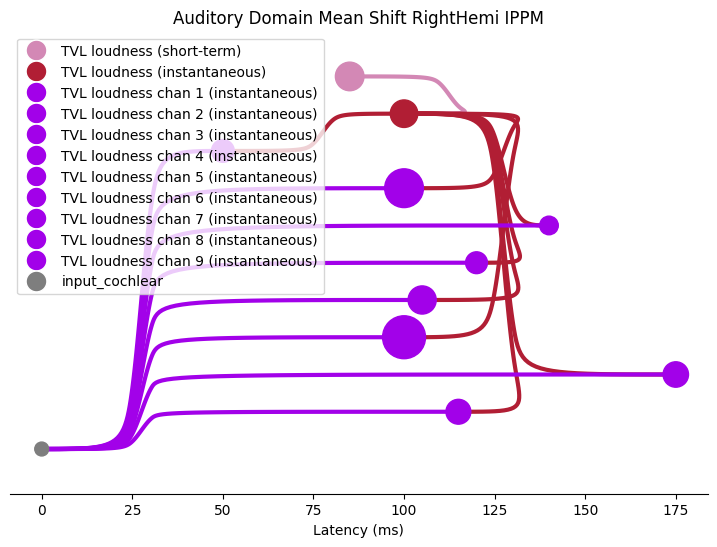

In [38]:
plotter.draw(s1_ms_r_ippm, s1_function_colour_overrides, 'Auditory Domain Mean Shift RightHemi IPPM', 6, 9)

#### Overall

In [39]:
avg_scores('Auditory Domain Mean Shift', s1_ms_indiv_frs, s1_ms_indiv_cvs)

Auditory Domain Mean Shift :: Avg FR: 1.000 | Avg CVS: 0.176


## Visual inputs

### Max Pooler

In [40]:
s2_mp_indiv_frs = []
s2_mp_indiv_cvs = []

#### LeftHemisphere

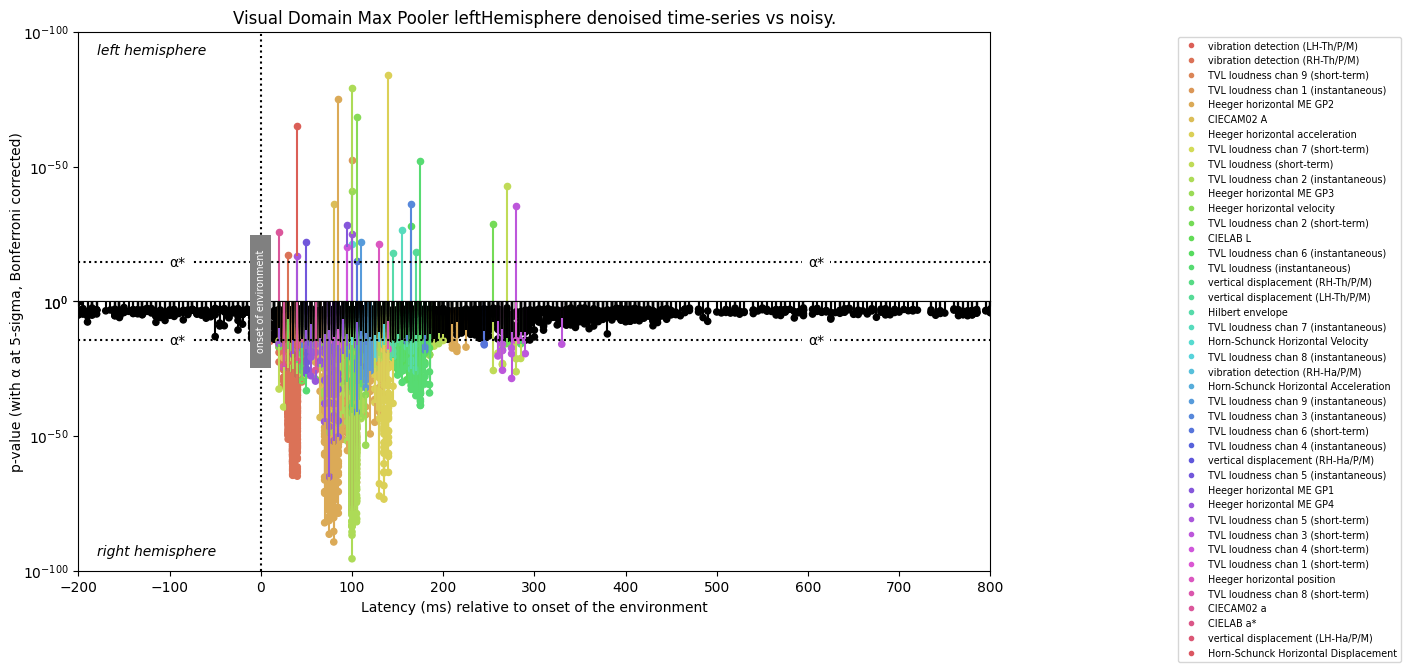

Visual Domain Max Pooler leftHemi :: Function Recall: 1.000 | Funcs Found: 5 | Total Funcs: 5
Visual Domain Max Pooler leftHemi :: Causality Violation: 0.000 | Violations Found: 0 | Total Arrows: 7


In [43]:
s2_mp_l = MaxPooler(threshold=1, bin_sz=1000)
s2_mp_l_fr, s2_mp_l_cvs, s2_mp_l_ippm = evaluate(hexels, s2_mp_l, s2_function_hier, s2_inputs, 'leftHemisphere', 'Visual Domain Max Pooler')
s2_mp_indiv_frs.append(s2_mp_l_fr)
s2_mp_indiv_cvs.append(s2_mp_l_cvs)
print_scores('Visual Domain Max Pooler leftHemi', s2_mp_l_fr, s2_mp_l_cvs)

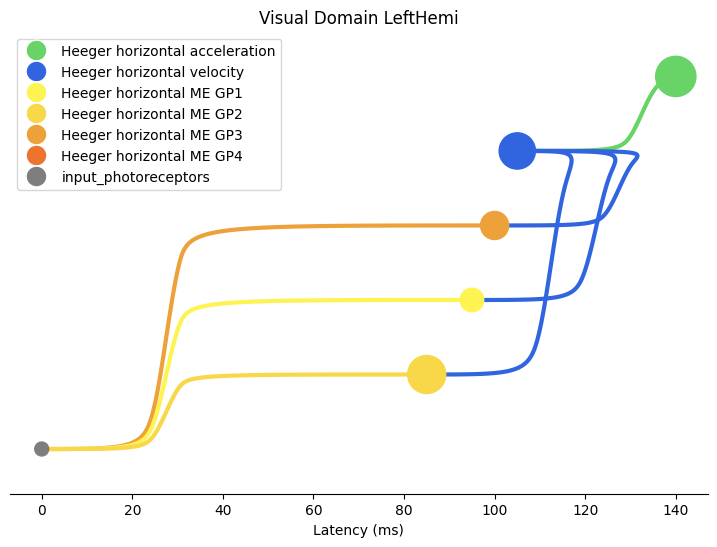

In [44]:
plotter.draw(s2_mp_l_ippm, s2_function_colour_overrides, 'Visual Domain LeftHemi', 6, 9)

#### RightHemisphere

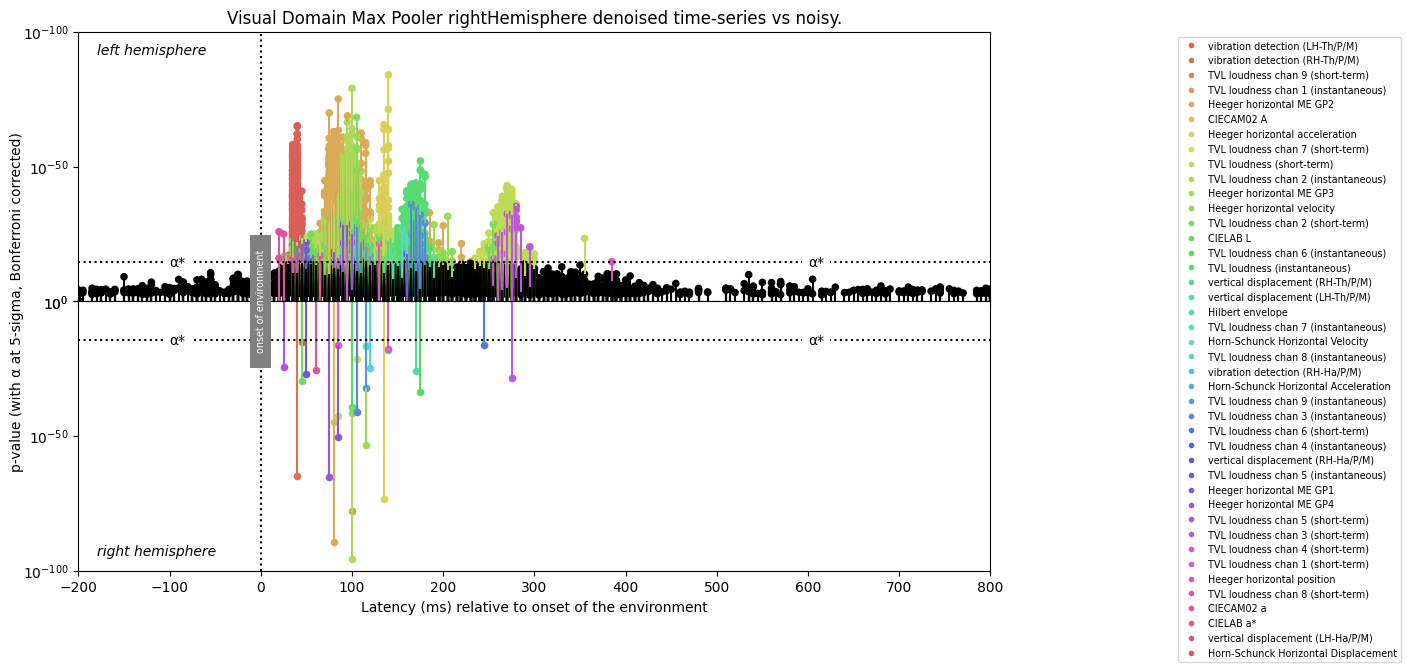

Visual Domain Max Pooler rightHemi :: Function Recall: 1.000 | Funcs Found: 5 | Total Funcs: 5
Visual Domain Max Pooler rightHemi :: Causality Violation: 0.143 | Violations Found: 1 | Total Arrows: 7


In [45]:
s2_mp_r = MaxPooler(threshold=1, bin_sz=1000)
s2_mp_r_fr, s2_mp_r_cvs, s2_mp_r_ippm = evaluate(hexels, s2_mp_l, s2_function_hier, s2_inputs, 'rightHemisphere', 'Visual Domain Max Pooler')
s2_mp_indiv_frs.append(s2_mp_r_fr)
s2_mp_indiv_cvs.append(s2_mp_r_cvs)
print_scores('Visual Domain Max Pooler rightHemi', s2_mp_r_fr, s2_mp_r_cvs)

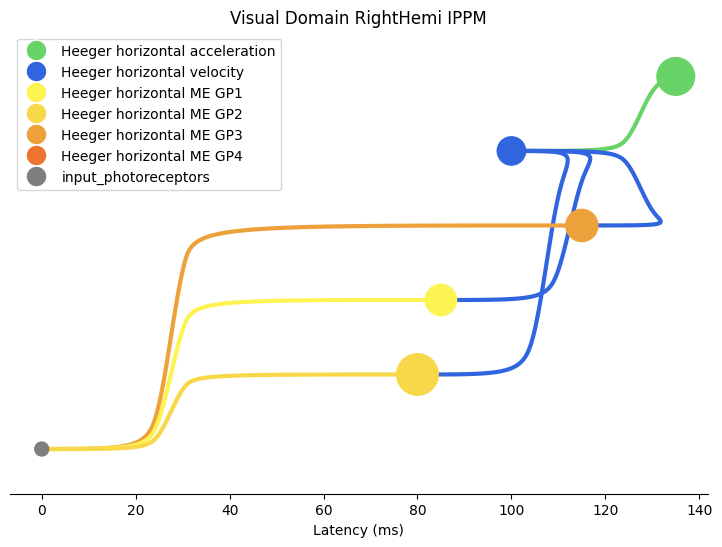

In [46]:
plotter.draw(s2_mp_r_ippm, s2_function_colour_overrides, 'Visual Domain RightHemi IPPM', 6, 9)

#### Overall

In [47]:
avg_scores('Visual Domain Max Pooler', s2_mp_indiv_frs, s2_mp_indiv_cvs)

Visual Domain Max Pooler :: Avg FR: 1.000 | Avg CVS: 0.071


### Adaptive Max Pooler

In [48]:
s2_amp_indiv_frs = []
s2_amp_indiv_cvs = []

#### LeftHemisphere

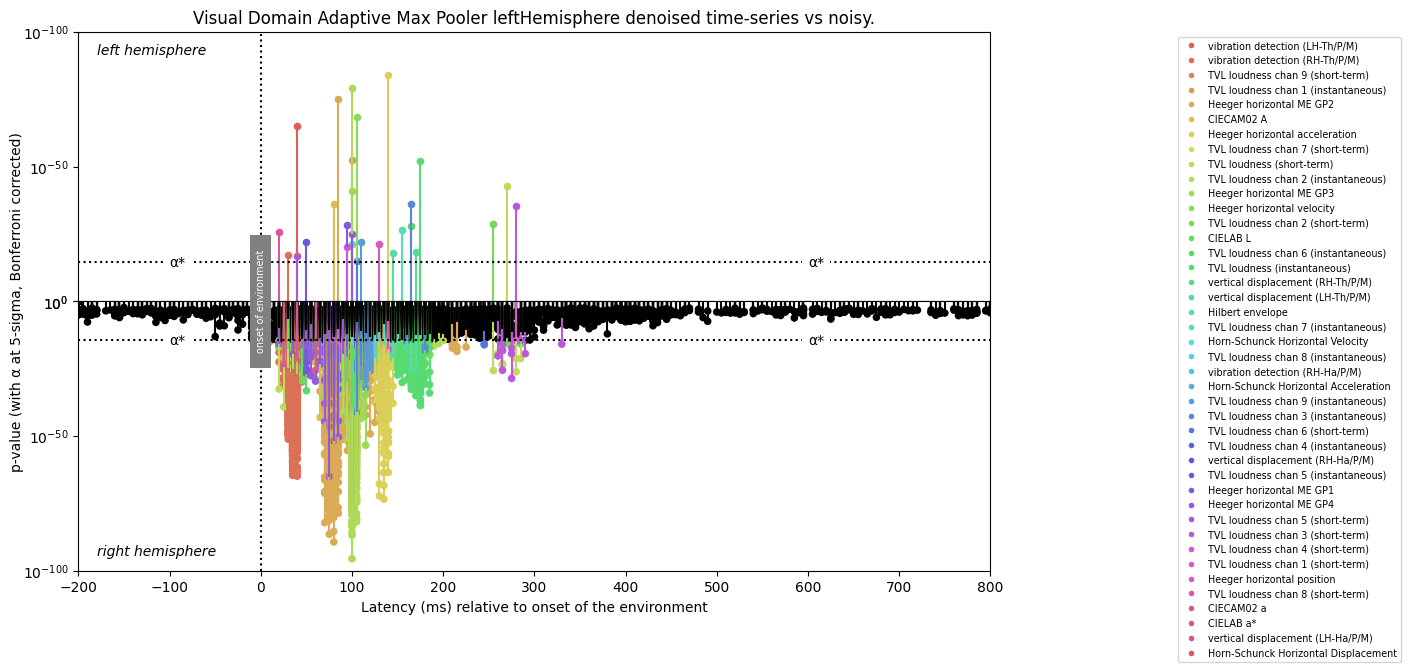

Visual Domain Adaptive Max Pooler leftHemi :: Function Recall: 1.000 | Funcs Found: 5 | Total Funcs: 5
Visual Domain Adaptive Max Pooler leftHemi :: Causality Violation: 0.000 | Violations Found: 0 | Total Arrows: 7


In [49]:
s2_amp_l = AdaptiveMaxPooler(threshold=1, base_bin_sz=1000)
s2_amp_l_fr, s2_amp_l_cvs, s2_amp_l_ippm = evaluate(hexels, s2_amp_l, s2_function_hier, s2_inputs, 'leftHemisphere', 'Visual Domain Adaptive Max Pooler')
s2_amp_indiv_frs.append(s2_amp_l_fr)
s2_amp_indiv_cvs.append(s2_amp_l_cvs)
print_scores('Visual Domain Adaptive Max Pooler leftHemi', s2_amp_l_fr, s2_amp_l_cvs)

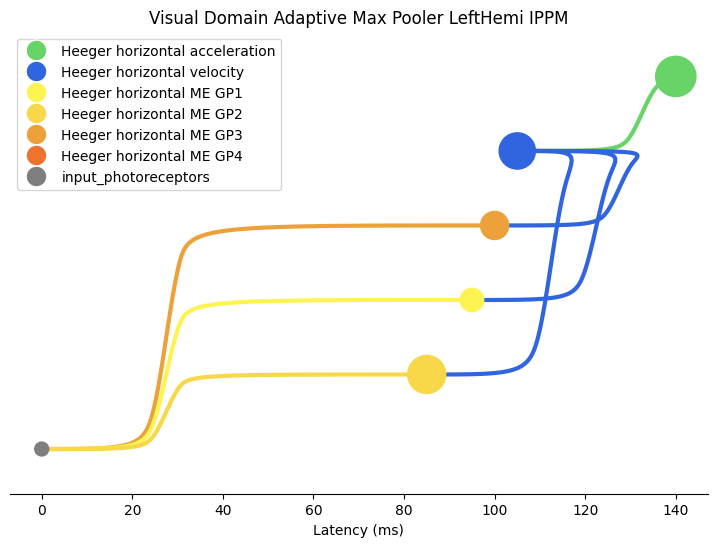

In [50]:
plotter.draw(s2_amp_l_ippm, s2_function_colour_overrides, 'Visual Domain Adaptive Max Pooler LeftHemi IPPM', 6, 9)

#### RightHemisphere

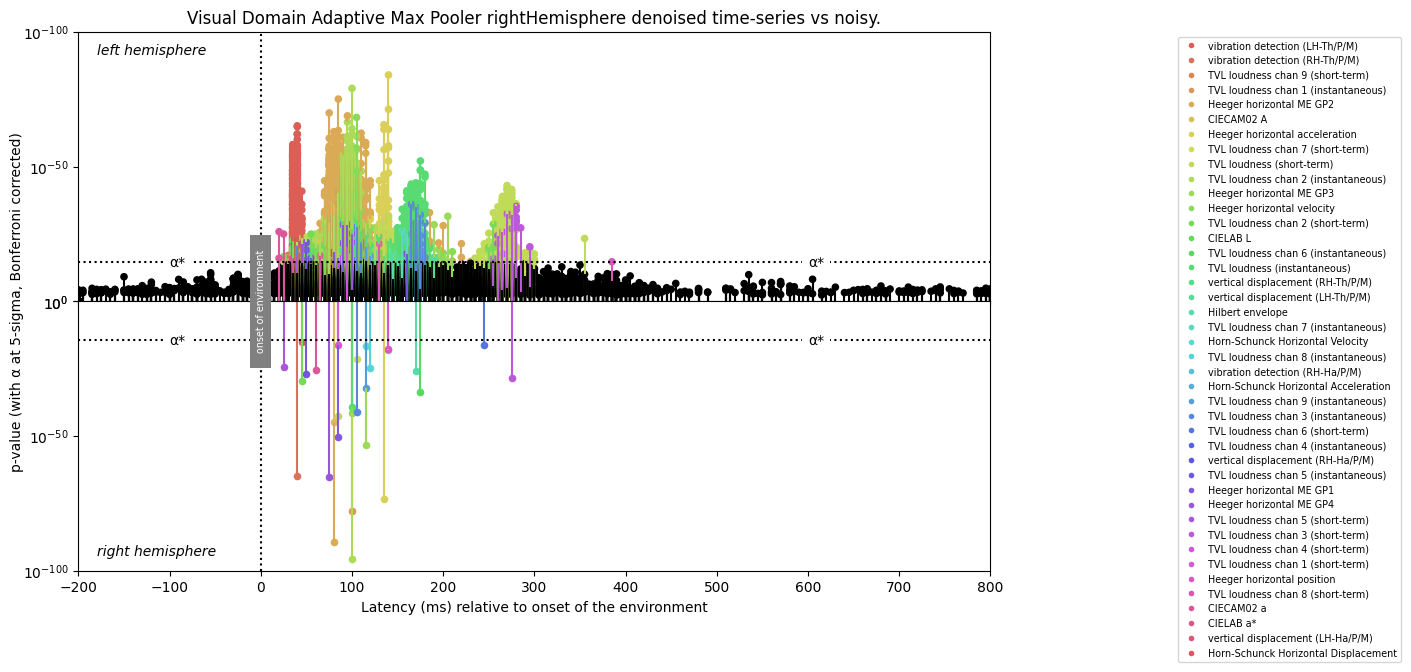

Visual Domain Adaptive Max Pooler rightHemi :: Function Recall: 1.000 | Funcs Found: 5 | Total Funcs: 5
Visual Domain Adaptive Max Pooler rightHemi :: Causality Violation: 0.143 | Violations Found: 1 | Total Arrows: 7


In [51]:
s2_amp_r = AdaptiveMaxPooler(threshold=1, base_bin_sz=1000)
s2_amp_r_fr, s2_amp_r_cvs, s2_amp_r_ippm = evaluate(hexels, s2_amp_l, s2_function_hier, s2_inputs, 'rightHemisphere', 'Visual Domain Adaptive Max Pooler')
s2_amp_indiv_frs.append(s2_amp_r_fr)
s2_amp_indiv_cvs.append(s2_amp_r_cvs)
print_scores('Visual Domain Adaptive Max Pooler rightHemi', s2_amp_r_fr, s2_amp_r_cvs)

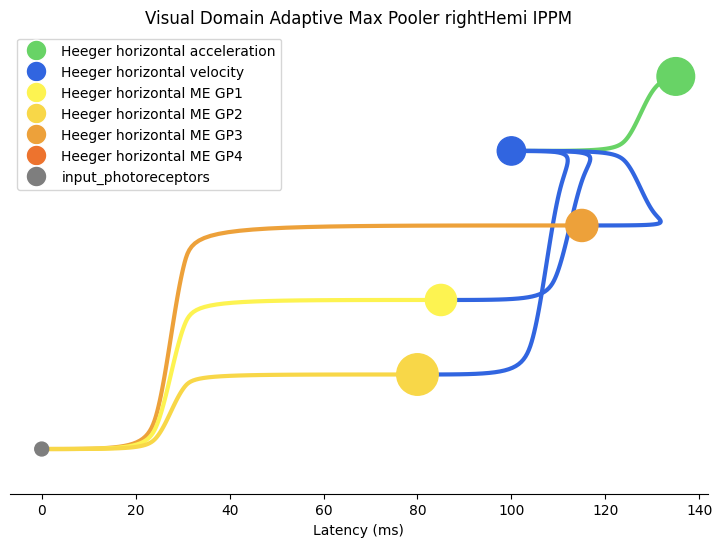

In [52]:
plotter.draw(s2_amp_r_ippm, s2_function_colour_overrides, 'Visual Domain Adaptive Max Pooler rightHemi IPPM', 6, 9)

#### Overall

In [53]:
avg_scores('Visual Domain Adaptive Max Pooler', s2_amp_indiv_frs, s2_amp_indiv_cvs)

Visual Domain Adaptive Max Pooler :: Avg FR: 1.000 | Avg CVS: 0.071


### GMM

In [54]:
s2_gmm_indiv_frs = []
s2_gmm_indiv_cvs = []

#### LeftHemisphere

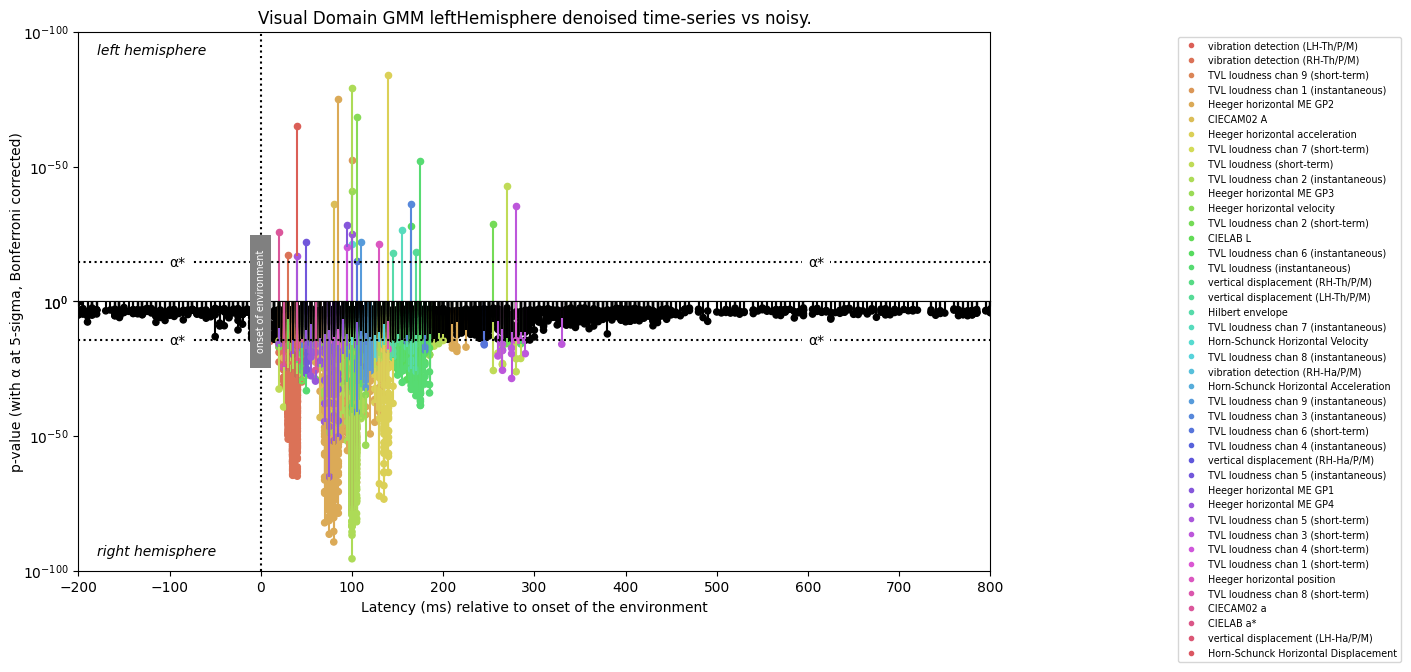

Visual Domain Max Pooler leftHemi :: Function Recall: 1.000 | Funcs Found: 5 | Total Funcs: 5
Visual Domain Max Pooler leftHemi :: Causality Violation: 0.000 | Violations Found: 0 | Total Arrows: 7


In [55]:
s2_gmm_l = GMM(max_gaussians=2, init_params='random_from_data', is_aic=False)
s2_gmm_l_fr, s2_gmm_l_cvs, s2_gmm_l_ippm = evaluate(hexels, s2_gmm_l, s2_function_hier, s2_inputs, 'leftHemisphere', 'Visual Domain GMM')
s2_gmm_indiv_frs.append(s2_gmm_l_fr)
s2_gmm_indiv_cvs.append(s2_gmm_l_cvs)
print_scores('Visual Domain Max Pooler leftHemi', s2_gmm_l_fr, s2_gmm_l_cvs)

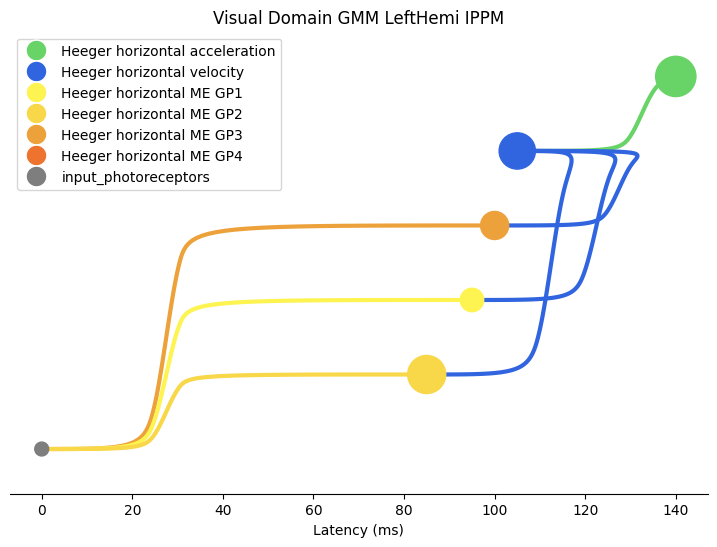

In [56]:
plotter.draw(s2_gmm_l_ippm, s2_function_colour_overrides, 'Visual Domain GMM LeftHemi IPPM', 6, 9)

#### RightHemisphere

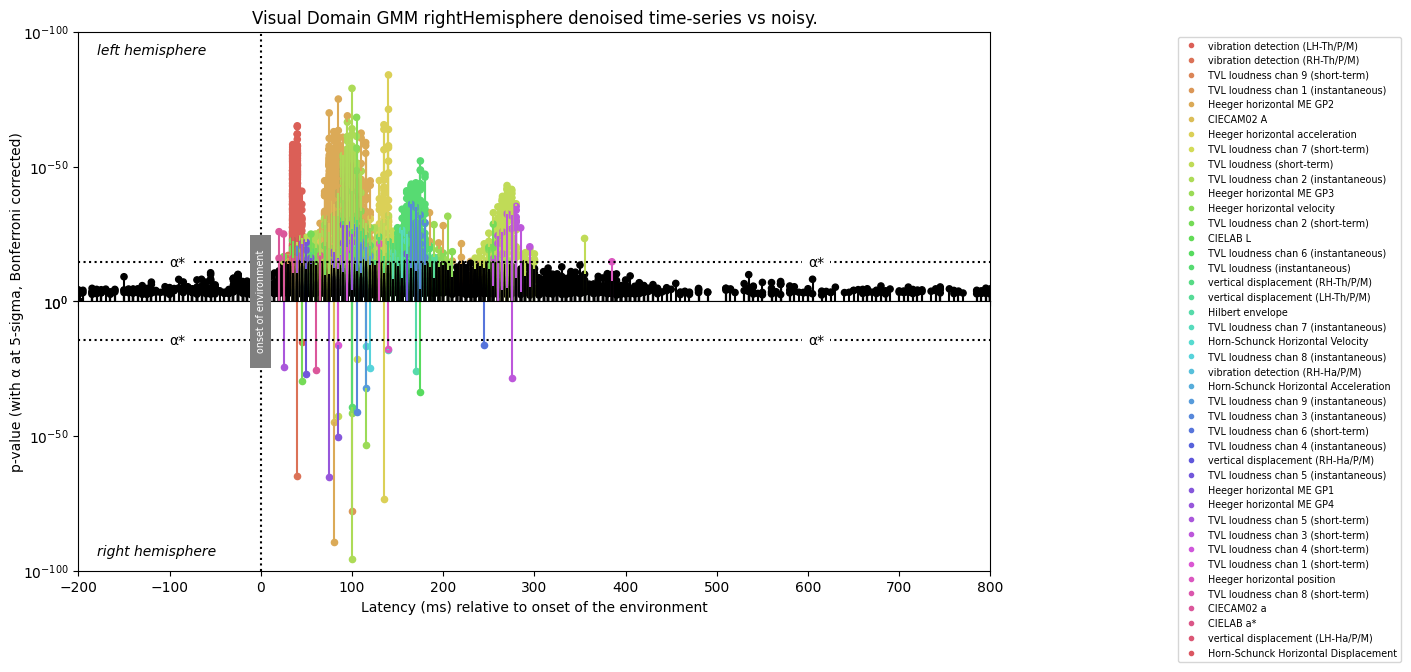

Visual Domain GMM rightHemi :: Function Recall: 1.000 | Funcs Found: 5 | Total Funcs: 5
Visual Domain GMM rightHemi :: Causality Violation: 0.143 | Violations Found: 1 | Total Arrows: 7


In [57]:
s2_gmm_r = GMM(max_gaussians=2, init_params='random_from_data', is_aic=False)
s2_gmm_r_fr, s2_gmm_r_cvs, s2_gmm_r_ippm = evaluate(hexels, s2_gmm_l, s2_function_hier, s2_inputs, 'rightHemisphere', 'Visual Domain GMM')
s2_gmm_indiv_frs.append(s2_gmm_r_fr)
s2_gmm_indiv_cvs.append(s2_gmm_r_cvs)
print_scores('Visual Domain GMM rightHemi', s2_gmm_r_fr, s2_gmm_r_cvs)

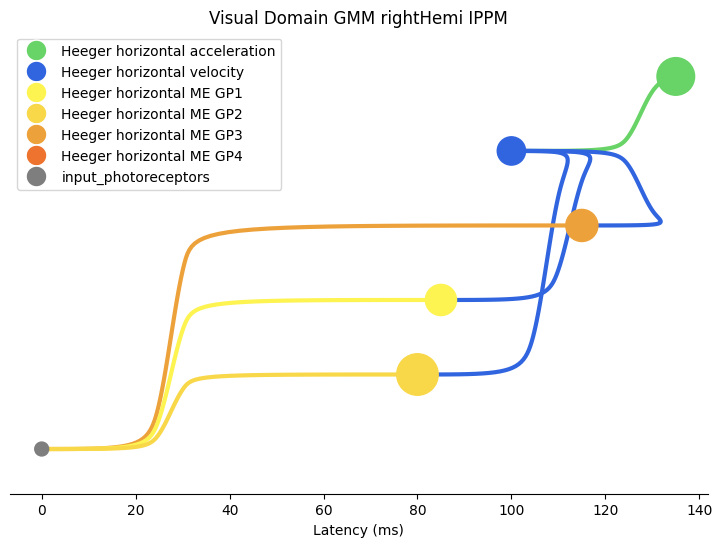

In [58]:
plotter.draw(s2_gmm_r_ippm, s2_function_colour_overrides, 'Visual Domain GMM rightHemi IPPM', 6, 9)

#### Overall

In [59]:
avg_scores('Visual Domain GMM', s2_gmm_indiv_frs, s2_gmm_indiv_cvs)

Visual Domain GMM :: Avg FR: 1.000 | Avg CVS: 0.071


### DBSCAN

In [60]:
s2_db_indiv_frs = []
s2_db_indiv_cvs = []

#### LeftHemisphere

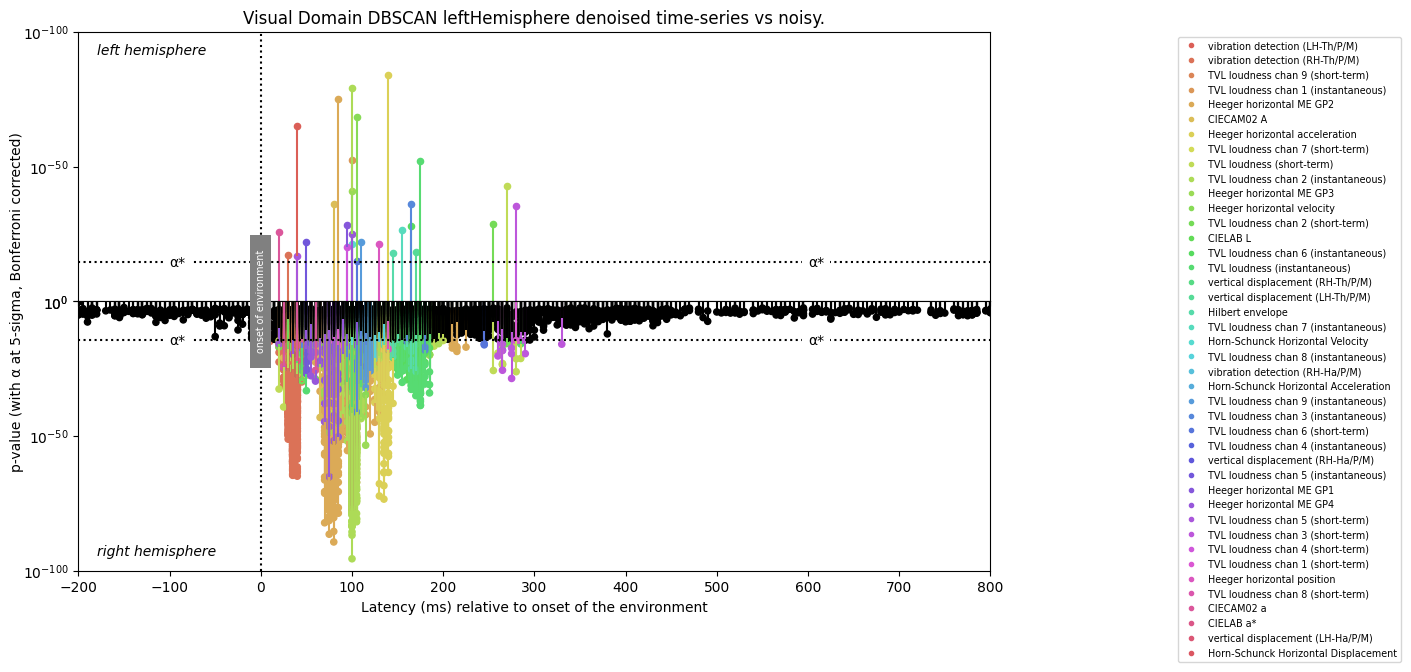

Visual Domain DBSCAN leftHemi :: Function Recall: 1.000 | Funcs Found: 5 | Total Funcs: 5
Visual Domain DBSCAN leftHemi :: Causality Violation: 0.000 | Violations Found: 0 | Total Arrows: 7


In [61]:
s2_db_l = DBSCAN(eps=500, min_samples=1)
s2_db_l_fr, s2_db_l_cvs, s2_db_l_ippm = evaluate(hexels, s2_db_l, s2_function_hier, s2_inputs, 'leftHemisphere', 'Visual Domain DBSCAN')
s2_db_indiv_frs.append(s2_db_l_fr)
s2_db_indiv_cvs.append(s2_db_l_cvs)
print_scores('Visual Domain DBSCAN leftHemi', s2_db_l_fr, s2_db_l_cvs)

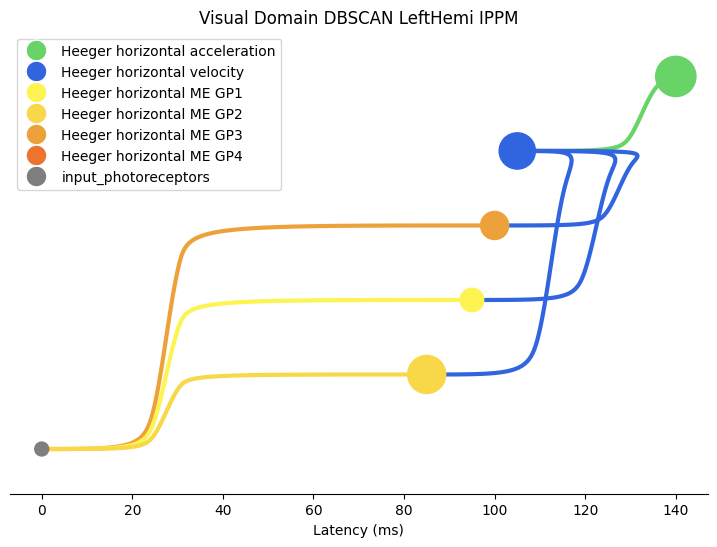

In [62]:
plotter.draw(s2_db_l_ippm, s2_function_colour_overrides, 'Visual Domain DBSCAN LeftHemi IPPM', 6, 9)

#### RightHemisphere

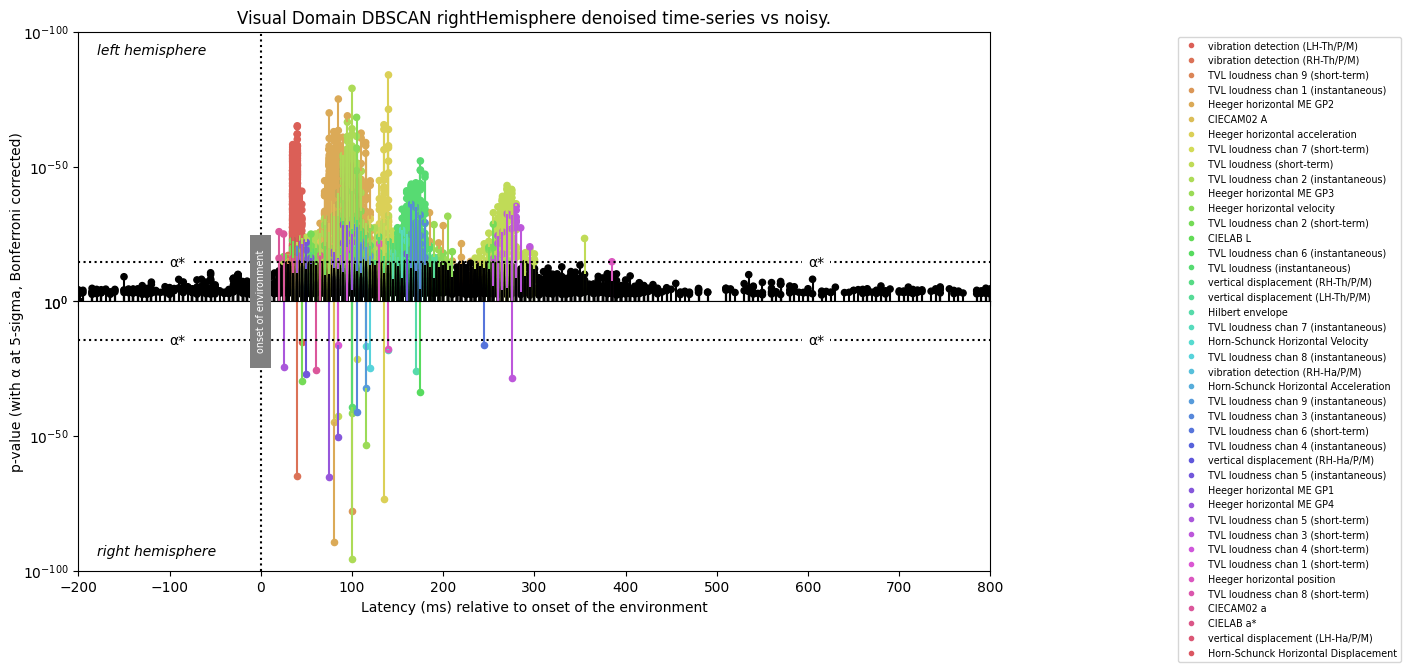

Visual Domain DBSCAN rightHemi :: Function Recall: 1.000 | Funcs Found: 5 | Total Funcs: 5
Visual Domain DBSCAN rightHemi :: Causality Violation: 0.143 | Violations Found: 1 | Total Arrows: 7


In [63]:
s2_db_r = DBSCAN(eps=1, min_samples=500)
s2_db_r_fr, s2_db_r_cvs, s2_db_r_ippm = evaluate(hexels, s2_db_l, s2_function_hier, s2_inputs, 'rightHemisphere', 'Visual Domain DBSCAN')
s2_db_indiv_frs.append(s2_db_r_fr)
s2_db_indiv_cvs.append(s2_db_r_cvs)
print_scores('Visual Domain DBSCAN rightHemi', s2_db_r_fr, s2_db_r_cvs)

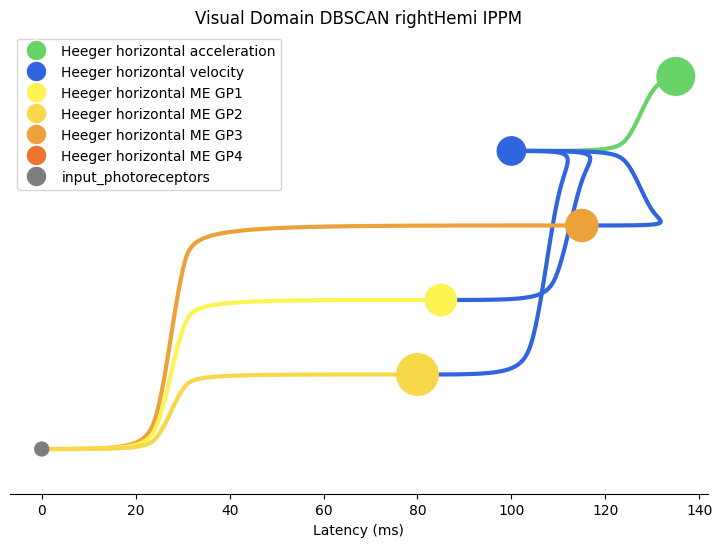

In [64]:
plotter.draw(s2_db_r_ippm, s2_function_colour_overrides, 'Visual Domain DBSCAN rightHemi IPPM', 6, 9)

#### Overall

In [65]:
avg_scores('Visual Domain DBSCAN', s2_db_indiv_frs, s2_db_indiv_cvs)

Visual Domain DBSCAN :: Avg FR: 1.000 | Avg CVS: 0.071


### Mean Shift

In [66]:
s2_ms_indiv_frs = []
s2_ms_indiv_cvs = []

#### LeftHemisphere

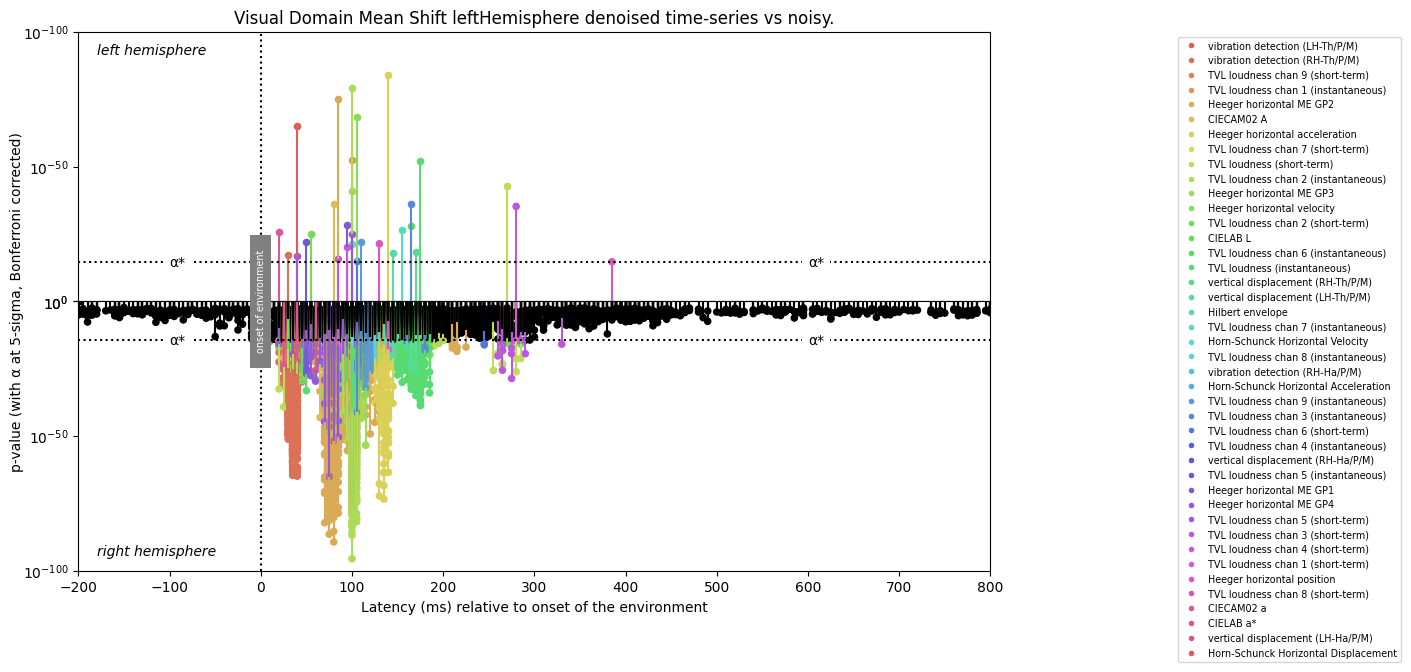

Visual Domain Mean Shift leftHemi :: Function Recall: 1.000 | Funcs Found: 5 | Total Funcs: 5
Visual Domain Mean Shift leftHemi :: Causality Violation: 0.000 | Violations Found: 0 | Total Arrows: 7


In [67]:
s2_ms_l = MeanShift(cluster_all=False, min_bin_freq=2, bandwidth=150)
s2_ms_l_fr, s2_ms_l_cvs, s2_ms_l_ippm = evaluate(hexels, s2_ms_l, s2_function_hier, s2_inputs, 'leftHemisphere', 'Visual Domain Mean Shift')
s2_ms_indiv_frs.append(s2_ms_l_fr)
s2_ms_indiv_cvs.append(s2_ms_l_cvs)
print_scores('Visual Domain Mean Shift leftHemi', s2_ms_l_fr, s2_ms_l_cvs)

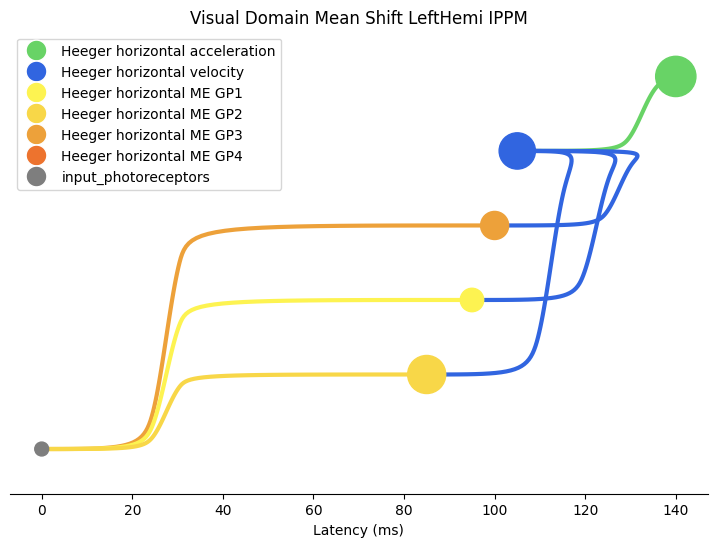

In [68]:
plotter.draw(s2_ms_l_ippm, s2_function_colour_overrides, 'Visual Domain Mean Shift LeftHemi IPPM', 6, 9)

#### RightHemisphere

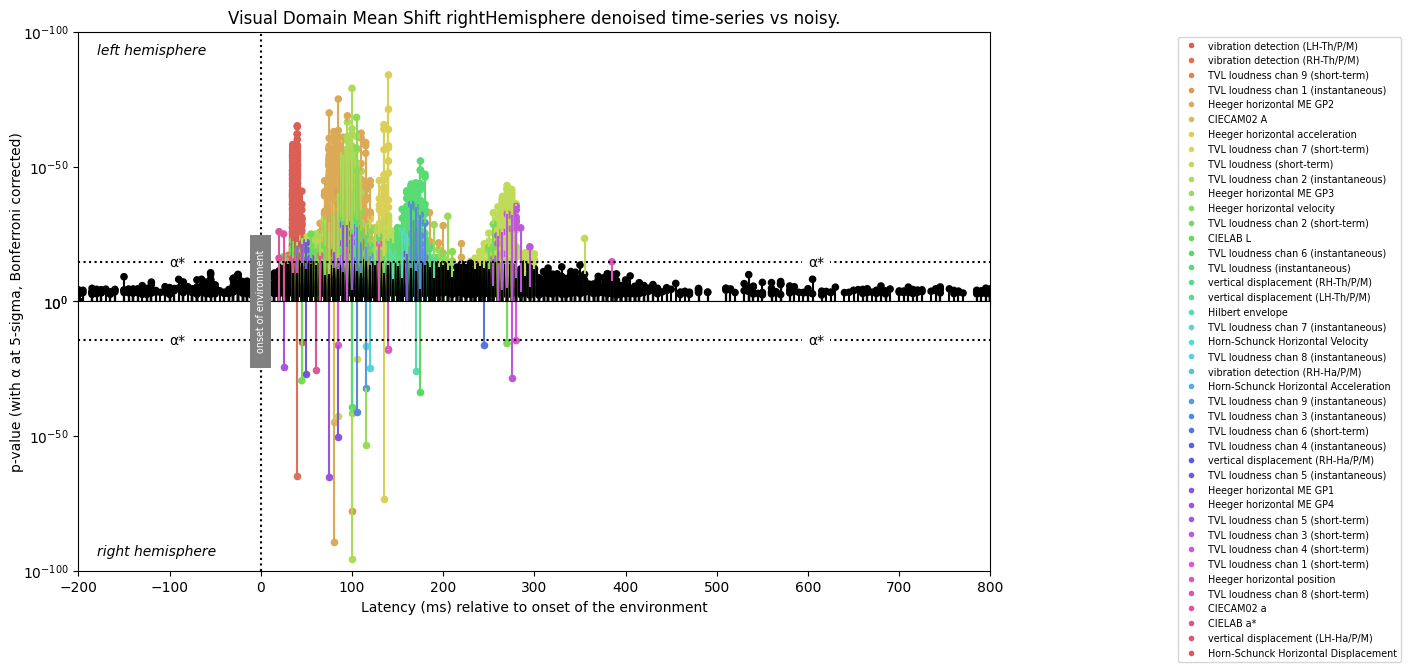

Visual Domain Mean Shift rightHemi :: Function Recall: 1.000 | Funcs Found: 5 | Total Funcs: 5
Visual Domain Mean Shift rightHemi :: Causality Violation: 0.143 | Violations Found: 1 | Total Arrows: 7


In [69]:
s2_ms_r = MeanShift(cluster_all=False, min_bin_freq=2, bandwidth=150)
s2_ms_r_fr, s2_ms_r_cvs, s2_ms_r_ippm = evaluate(hexels, s2_ms_l, s2_function_hier, s2_inputs, 'rightHemisphere', 'Visual Domain Mean Shift')
s2_ms_indiv_frs.append(s2_ms_r_fr)
s2_ms_indiv_cvs.append(s2_ms_r_cvs)
print_scores('Visual Domain Mean Shift rightHemi', s2_ms_r_fr, s2_ms_r_cvs)

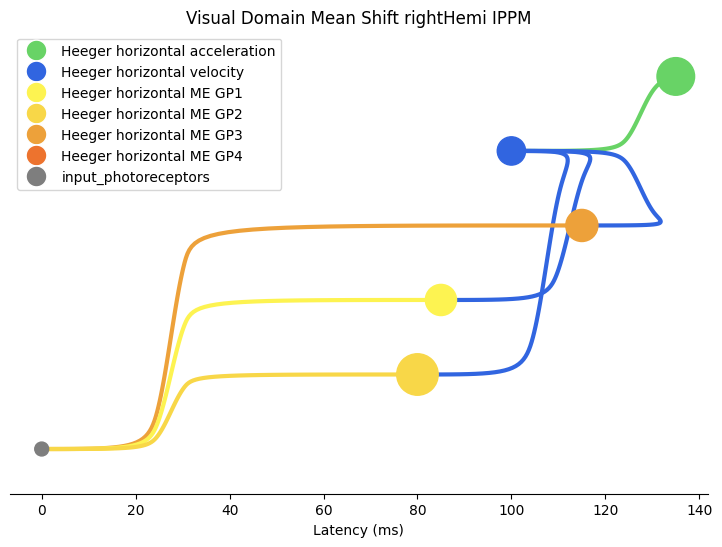

In [70]:
plotter.draw(s2_ms_r_ippm, s2_function_colour_overrides, 'Visual Domain Mean Shift rightHemi IPPM', 6, 9)

#### Overall

In [71]:
avg_scores('Visual Domain Mean Shift', s2_ms_indiv_frs, s2_ms_indiv_cvs)

Visual Domain Mean Shift :: Avg FR: 1.000 | Avg CVS: 0.071
